In [1]:
#%reset
import glob
import numpy as np
from numpy import inf
from math import isnan
import warnings
warnings.filterwarnings("ignore")
import sys
import asaplib
from os import path

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from adjustText import adjust_text
from matplotlib import ticker, cm
import matplotlib.colors as colors

from tablelegend import *

%matplotlib inline

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [3]:
from scipy import stats
from scipy import interpolate
from scipy import integrate
from scipy.interpolate import griddata

In [4]:
from thermodynamic_integration import *

In [5]:
from asaplib.plot import plot_styles
plot_styles.set_nice_font()

font = {'size': 12}
plt.rc('font', **font)

plt.rcParams.update({'figure.max_open_warning': 0})

# setups for making plots
from matplotlib import cm

#norm = cm.colors.Normalize(vmax=30, vmin=0)
#cmap = cm.Set1

In [6]:
kbK_2_ev = 0.00008661733
evperh2o_2_kjperg = 5.3602963
A2perps_2_cm2pers = 0.0001

# constants
A3GPa2ev = 0.0062415091 # A^3*GPa in eV

In [7]:
print(3000*kbK_2_ev)

0.25985199


# Read results

In [8]:
temperature_list = [1000, 1250, 1500, 1750, 2000, 2500, 3000, 4000, 5000]
pressure_list = [10, 20, 50, 100, 150, 200, 300, 400, 600]
sys_list = ['fcc','bcc','X','Pbcm-8','Pbcm','liquid']

# read the MLP results for RDF
npt_dir = "./npt/"
sl_dir = "./sl-plumed-more/"
literature_dir = '../../selected-literature/'
exp_dir = literature_dir+"experiment/"
theory_dir = literature_dir+"theory/"

In [9]:
acronym = {"fcc":"fcc", "bcc":"bcc", "Pbcm":"hcp","Pbcm-8":"hcp", "liquid":"liquid"}

# read previous results 

In [10]:
past_exp = {}

In [11]:
past_exp['Millot2019-bcc'] = np.genfromtxt(exp_dir+"Millot2019-superionic-ice/MillotCoppari2019-bcc.dat")
# p(GPa) p_error(GPa) T(K) T_error(K) rho(g/cc) rho_error(g/cc)
#print(past_exp['Millot2019-bcc'])
past_exp['Millot2019-fcc'] = np.genfromtxt(exp_dir+"Millot2019-superionic-ice/MillotCoppari2019-fcc.dat")

In [12]:
# melting lines
# T (K) Terror (K) P(GPa) Perror (GPa)
past_exp['Queyroux2020-melting'] = np.genfromtxt(exp_dir+"Queyroux2020-melting/Queyroux2020-melting.dat")

#p(GPa)	T(K)
past_exp['Schwager2004-melting'] = np.genfromtxt(exp_dir+"Schwager2004-melting-iceVII-X/Schwager2004.dat")
past_exp['Schwager2008-melting'] = \
np.genfromtxt(exp_dir+"Schwager2008-melting-iceVII-X-solid-solid-transition/Schwager2008-melting.dat")

# actually may be ice<->superionic
#p(GPa)	T(K)
past_exp['Goncharov2005-melting'] = np.genfromtxt(exp_dir+"Goncharov2005-melting-solid-solid/Goncharov2005-melting.dat")

In [13]:
# on arXiv
#p(GPa)	T(K)
past_exp['Prakapenka2020-bcc'] = np.genfromtxt(exp_dir+"Prakapenka2020/Prakapenka2020-superionic-bcc-XRD.dat")

past_exp['Prakapenka2020-fcc'] = np.genfromtxt(exp_dir+"Prakapenka2020/Prakapenka2020-superionic-fcc-XRD.dat")

past_exp['Prakapenka2020-ice'] = np.genfromtxt(exp_dir+"Prakapenka2020/Prakapenka2020-ice-XRD.dat")


In [14]:
past_theory = {}

In [15]:
#p(GPa)	T(K)
past_theory['French2016-bccfcc'] = np.genfromtxt(theory_dir+"French2016/French2016superionicBCC-superionicFCC.dat")

#p(GPa)	T(K)
past_theory['Wilson2013-melting'] = np.genfromtxt(theory_dir+"Wilson2013/Wilson2013-fluid-superionic.dat")

past_theory['Wilson2013-ice-superionic'] = np.genfromtxt(theory_dir+"Wilson2013/Wilson-solid-superionic.dat")

# T[K] P[GPa] P_error[GPa]
past_theory['Sun2015-bcc-cp'] = np.genfromtxt(theory_dir+"Sun2015/bcc-2-cp.dat")


# Planetary interior conditions for Neptune 
# MassðM Pressure (GPa) Radius Temperature (K) Density (g/ccm)
past_theory['Nettelmann2012-neptune'] = np.genfromtxt(theory_dir+"Nettelmann2012/table_N1.dat")
# for Uranus 
# mass	P	radius	?	T	rho
past_theory['Nettelmann2012-uranus'] = np.genfromtxt(theory_dir+"Nettelmann2012/table_U1.dat")

# #m [m_Earth], P [GPa], R [R_earth], T [K], rho [g/cc]
past_theory['Scheibe2019-neptune'] = np.genfromtxt(theory_dir+"Scheibe2019/Scheibe19_Neptune2_MazH2O.dat")
past_theory['Scheibe2019-uranus'] = np.genfromtxt(theory_dir+"Scheibe2019/Scheibe19_Uranus2_MazH2O.dat")

# tm
# P[GPa] T[K]
past_theory['Redmer2011-bcc-melt'] = np.genfromtxt(theory_dir+"Redmer2011/Redmer2011-melting-superionicBCC.dat")
past_theory['Redmer2011-VII-melt'] = np.genfromtxt(theory_dir+"Redmer2011/Redmer2011-melting-iceVII.dat")
past_theory['Redmer2011-VII-bcc'] = np.genfromtxt(theory_dir+"Redmer2011/Redmer2011-ices-superionicBCC.dat")

(500.0, 6500.0)

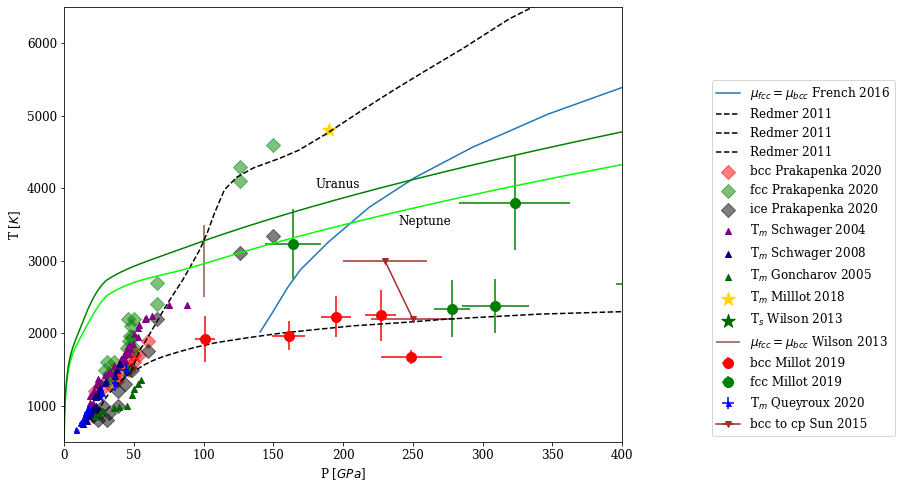

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(10,8)

# experiments
data_now = past_exp['Millot2019-bcc']
ax.errorbar(data_now[:,0], data_now[:,2], 
            yerr=data_now[:,3], xerr=data_now[:,1],
            label='bcc Millot 2019',
            marker='o', c='red', markersize=10,
           ls='')

data_now = past_exp['Millot2019-fcc']
ax.errorbar(data_now[:,0], data_now[:,2], 
            yerr=data_now[:,3], xerr=data_now[:,1],
            label='fcc Millot 2019',
            marker='o', c='green', markersize=10,
           ls='')

# Prakapenka2020
data_now = past_exp['Prakapenka2020-bcc']
ax.scatter(data_now[:,0], data_now[:,1], 
            label='bcc Prakapenka 2020',
            marker='D', c='red',s=100,facecolors='None', alpha=0.5)

data_now = past_exp['Prakapenka2020-fcc']
ax.scatter(data_now[:,0], data_now[:,1], 
            label='fcc Prakapenka 2020',
            marker='D', c='green',s=100,facecolors='None', alpha=0.5)

data_now = past_exp['Prakapenka2020-ice']
ax.scatter(data_now[:,0], data_now[:,1], 
            label='ice Prakapenka 2020',
            marker='D', c='k',s=100,facecolors='None', alpha=0.5)


data_now = past_exp['Queyroux2020-melting']
ax.errorbar(data_now[:,2], data_now[:,0], 
            yerr=data_now[:,1], xerr=data_now[:,3],
            label='T$_m$ Queyroux 2020',
            marker='^', c='blue', markersize=5,
           ls='')

data_now = past_exp['Schwager2004-melting']
ax.scatter(data_now[:,0], data_now[:,1], 
            label='T$_m$ Schwager 2004',
            marker='^', c='purple')
data_now = past_exp['Schwager2008-melting']
ax.scatter(data_now[:,0], data_now[:,1], 
            label='T$_m$ Schwager 2008',
            marker='^', c='navy')

data_now = past_exp['Goncharov2005-melting']
ax.scatter(data_now[:,0], data_now[:,1], 
            label='T$_m$ Goncharov 2005',
            marker='^', c='darkgreen')

# millot 2018
ax.scatter([190], [4800], 
            label='T$_m$ Milllot 2018',
            marker='*', s=200, c='gold')

# theory
data_now = past_theory['French2016-bccfcc'] 
ax.plot(data_now[:,0], data_now[:,1], 
            label='$\mu_{fcc}=\mu_{bcc}$ French 2016',
            ls='-', c='tab:blue')

data_now = past_theory['Wilson2013-ice-superionic']
ax.scatter(data_now[:,0], data_now[:,1], 
            label='T$_s$ Wilson 2013',
            marker='*', c='darkgreen',s=200)


data_now = past_theory['Sun2015-bcc-cp']
ax.errorbar(data_now[:,1], data_now[:,0], 
            yerr=None, xerr=data_now[:,2],
            label='bcc to cp Sun 2015',
            marker='v', c='brown')

data_now = past_theory['Redmer2011-bcc-melt']
ax.plot(data_now[:,0], data_now[:,1], 
            label='Redmer 2011',
            ls='--', c='k')
data_now = past_theory['Redmer2011-VII-melt'] 
ax.plot(data_now[:,0], data_now[:,1], 
            label='Redmer 2011',
            ls='--', c='k')
data_now = past_theory['Redmer2011-VII-bcc']
ax.plot(data_now[:,0], data_now[:,1], 
            label='Redmer 2011',
            ls='--', c='k')

# Wilson
ax.vlines(100, 2500, 3500, colors='tab:brown', 
          linestyles='solid', label='$\mu_{fcc}=\mu_{bcc}$ Wilson 2013')

# planatary conditions
#data_now = past_theory['Nettelmann2012-neptune'] 
#ax.plot(data_now[:,1], data_now[:,3], 
#            ls='-', c='lime')
#ax.text(200,4000,'Neptune')

#data_now = past_theory['Nettelmann2012-uranus'] 
#ax.plot(data_now[:,1], data_now[:,4], 
#            ls='-', c='lime')
#ax.text(200,4500,'Uranus')

# planatary conditions
data_now = past_theory['Scheibe2019-neptune'] 
ax.plot(data_now[:,1], data_now[:,3], 
            ls='-', c='lime')
ax.text(240,3500,'Neptune')

data_now = past_theory['Scheibe2019-uranus'] 
ax.plot(data_now[:,1], data_now[:,3], 
            ls='-', c='green')
ax.text(180,4000,'Uranus')

ax.legend(loc='lower right', bbox_to_anchor=(1.5, 0))
ax.set_xlabel('P [$GPa$]')
ax.set_ylabel("T [$K$]")
ax.set_xlim([0,400])
ax.set_ylim([500,6500])

## diffusivity 

In [17]:
# P[GPa] T[K] D_o[0], D_o[1], D_h[0], D_h[1] in cm2/s

mlpD = {}
allD = {}

for s in ['fcc','bcc']:
    mlpD[s] = np.genfromtxt(npt_dir+'D-'+s+'.dat')
    
    # [p, t, D_o[0], D_o[1], D_h[0], D_h[1]]
    allD[s] = np.asarray([ e for e in mlpD[s] if np.squeeze(e)[2] > 0])

### T_s lines

In [18]:
mlpTs = {}

for s in ['fcc','bcc','hcp']:
    # 'P[GPa] T[K]'
    mlpTs[s] = np.genfromtxt("./mu-data/Ts-"+s+".dat")

### COLVAR 

In [19]:
# P[GPa] T[K] fccubic error_fccubic m6 error_m6

mlpcolvar = {}
mlpcolvar_by_P = {}

for s in sys_list:
    print(s)
    mlpcolvar[s] = np.genfromtxt(npt_dir+'COLVAR-'+s+'.dat')
    mlpcolvar_by_P[s] = {}
    for p in pressure_list:
        mlpcolvar_by_P[s][p] = [ mlpcolvar[s][mlpcolvar[s][:,0]==p]]

fcc
bcc
X
Pbcm-8
Pbcm
liquid


Text(0.5, 0, 'T [$K$]')

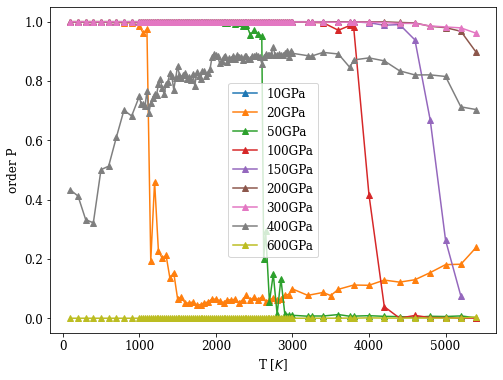

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)

for i, p in enumerate(pressure_list):
    sys_now = 'Pbcm'
    colvar_tmp = np.squeeze(mlpcolvar_by_P[sys_now][p])
    colvar_tmp = colvar_tmp[colvar_tmp[:,1].argsort()]
    ax.plot(colvar_tmp[:,1], colvar_tmp[:,4], c=cm.tab10(i), marker='^', label=str(p)+'GPa',ls='-')

    #sys_now = 'fcc'
    #colvar_tmp = np.squeeze(mlpcolvar_by_P[sys_now][p])
    #colvar_tmp = colvar_tmp[colvar_tmp[:,1].argsort()]
    #ax.plot(colvar_tmp[:,1], colvar_tmp[:,4], c=cm.tab10(i), marker='v', ls='--')
    
ax.legend()
#ax.set_ylim([4, 15])
ax.set_ylabel('order P')
ax.set_xlabel("T [$K$]")

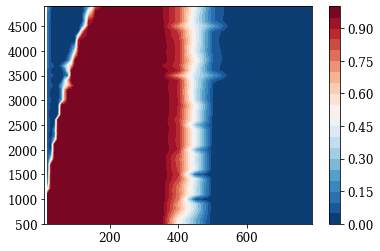

In [21]:
# test grid data
# P[GPa] T[K] fccubic m6
data = mlpcolvar['Pbcm'][:,[0,1,4]]

fig, ax = plt.subplots()

# regular grid covering the domain of the data
X,Y = np.meshgrid(np.arange(10, 800, 10), np.arange(500, 5000, 100))

grid_z1 = griddata(data[:,[0,1]], data[:,2], (X, Y), method='linear')

#H_T = interpolate.interp1d(T_int, grid_z1)

cntr1 = ax.contourf(X, Y, grid_z1, levels=21, cmap="RdBu_r")

fig.colorbar(cntr1, ax=ax)

### EOS

In [22]:
mlpeos = {}
mlpeos_by_P = {}

for s in ['fcc','bcc', 'Pbcm', 'X','liquid','Pbcm-8']:
    try:
        mlpeos[s] = np.genfromtxt(npt_dir+'EOS-'+s+'-cleaned.dat')
    except:
        # P[GPa] T[K] volume[A^3/molecule] PE[eV/molecule]
        eos_tmp = np.genfromtxt(npt_dir+'EOS-'+s+'.dat')
        if s=='fcc':
            mlpeos[s] = np.asarray([x for x in eos_tmp if x[2] > 2 and \
                            (x[0]>300 or griddata(mlpcolvar[s][:,[0,1]], mlpcolvar[s][:,2], 
                                                  (x[0], x[1]), method='linear'))>0.8])
        elif s in ['bcc', 'Pbcm', 'X','Pbcm-8']:
            mlpeos[s] = np.asarray([x for x in eos_tmp if x[2] > 2 and \
                            (x[0]>300 or griddata(mlpcolvar[s][:,[0,1]], mlpcolvar[s][:,4], 
                                                  (x[0], x[1]), method='linear')>0.8)])
        elif s=='liquid':
            mlpeos[s] = np.asarray([x for x in eos_tmp if x[2] > 2 and \
                            griddata(mlpcolvar[s][:,[0,1]], mlpcolvar[s][:,4], 
                                     (x[0], x[1]), method='linear')<0.1])            
        np.savetxt(npt_dir+'EOS-'+s+'-cleaned.dat', mlpeos[s])
        
    mlpeos_by_P[s] = {}
    for p in pressure_list:
        mlpeos_by_P[s][p] = [ mlpeos[s][mlpeos[s][:,0]==p]]

Text(0.5, 0, 'T [K]')

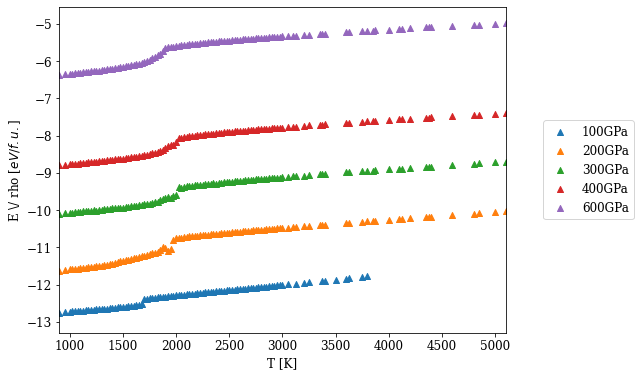

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)

sys_now = 'Pbcm'

for i, p in enumerate([100,200,300,400,600]):
    eos_tmp = np.squeeze(mlpeos_by_P[sys_now][p])
    ax.scatter(eos_tmp[:,1], eos_tmp[:,4], c=cm.tab10(i), marker='^', label=str(p)+'GPa')
    
ax.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
ax.set_xlim([900, 5100])
ax.set_ylabel('E \/ rho [$eV/f.u.$]')
ax.set_xlabel("T [K]")

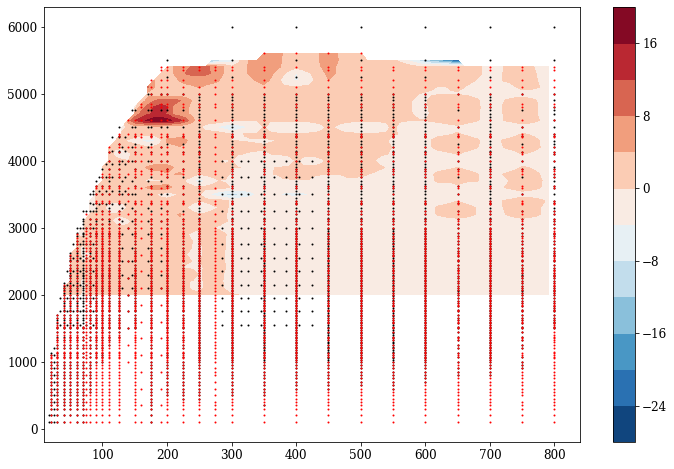

In [24]:
# test grid data
# P[GPa] T[K] volume[A^3/molecule] PE[eV/molecule]

# note: run more liquid at low P (5-10 GPa), and X at low P
sys_1='fcc'
sys_2='Pbcm'
data = mlpeos[sys_1][:,[0,1,2]]
#np.asarray([x for x in mlpeos[sys_1][:,[0,1,2]] if list(x[0:2]) in mlpeos[sys_2][:,[0,1]].tolist() ])
data_2 = mlpeos[sys_2][:,[0,1,2]]
#np.asarray([x for x in mlpeos[sys_2][:,[0,1,2]] if list(x[0:2]) in mlpeos[sys_1][:,[0,1]].tolist() ])

fig, ax = plt.subplots(figsize=(12,8))

# regular grid covering the domain of the data
X,Y = np.meshgrid(np.arange(10, 800, 10), np.arange(2000, 5800, 100))

grid_z1 = griddata(data[:,[0,1]], data[:,2]*data[:,0], (X, Y), method='linear')
grid_z2 = griddata(data_2[:,[0,1]], data_2[:,2]*data_2[:,0], (X, Y), method='linear')

plt.plot(mlpeos[sys_1][:,0], mlpeos[sys_1][:,1], 'k.', ms=2)
plt.plot(mlpeos[sys_2][:,0], mlpeos[sys_2][:,1], 'r.', ms=2)

cntr1 = ax.contourf(X, Y, grid_z2-grid_z1, levels=11, cmap="RdBu_r")

fig.colorbar(cntr1, ax=ax)


#CS = ax.contour(X_bcc_fcc, Y_bcc_fcc, dmu_bcc_fcc, levels=[ 0.0],linewidths=1.5, colors='k')

### NNP to DFT correction (mu_DFT - mu_NNP)

In [25]:
corr_dir = '../../fep/'

mu_nnp2dft = {}

# Pressure[bar] Temperature[K]  mu_DFT-mu_NNP[meV/molecule] (mu_DFT-mu_NNP)_error[meV/molecule]

for s in ['fcc', 'bcc', 'liquid', 'Pbcm']:
    mu_nnp2dft[s] = []
    corr_list = glob.glob(corr_dir+"merge-all/dmu-"+s+".dat")
    print(corr_list)
    
    for c in corr_list:
        if len(mu_nnp2dft[s]) == 0 :
            mu_nnp2dft[s] = np.genfromtxt(c)
        else:
            mu_nnp2dft[s] = np.vstack((mu_nnp2dft[s],np.genfromtxt(c)))

['../../fep/merge-all/dmu-fcc.dat']
['../../fep/merge-all/dmu-bcc.dat']
['../../fep/merge-all/dmu-liquid.dat']
['../../fep/merge-all/dmu-Pbcm.dat']


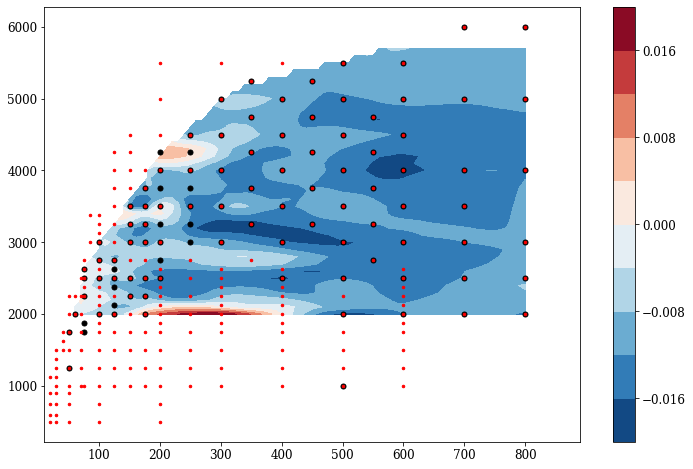

In [26]:
# test grid data
# Pressure[bar] Temperature[K]  mu_DFT-mu_NNP[meV/molecule] (mu_DFT-mu_NNP)_error[meV/molecule]

sys_1='Pbcm'
sys_2='fcc'
data = mu_nnp2dft[sys_1][:,[0,1,2]]
data_2 = mu_nnp2dft[sys_2][:,[0,1,2]]

fig, ax = plt.subplots(figsize=(12,8))

# regular grid covering the domain of the data
X,Y = np.meshgrid(np.arange(10, 900, 10), np.arange(2000, 5800, 100))

grid_z1 = griddata(data[:,[0,1]], data[:,2], (X, Y), method='cubic')
grid_z2 = griddata(data_2[:,[0,1]], data_2[:,2], (X, Y), method='cubic')

cntr1 = ax.contourf(X, Y, grid_z1-grid_z2, levels=11, cmap="RdBu_r")

plt.plot(mu_nnp2dft[sys_1][:,0], mu_nnp2dft[sys_1][:,1], 'k.', ms=10)
plt.plot(mu_nnp2dft[sys_2][:,0], mu_nnp2dft[sys_2][:,1], 'r.', ms=5)

fig.colorbar(cntr1, ax=ax)


#CS = ax.contour(X_bcc_fcc, Y_bcc_fcc, dmu_bcc_fcc, levels=[ 0.0],linewidths=1.5, colors='k')

### NQEs

In [27]:
nqe_dir = './pimd/'
y_list = [1, 0.707107, 0.5, 0.25,0]
mu_nqe = {}
mu_nqe_by_y = {}

# y=sqrt(m0/m) temperature[K] pressure[bar] T_cv[meV/molecule] T_cv_error[meV/molecule]

for s in ['fcc', 'bcc', 'liquid', 'Pbcm']:
    mu_nqe[s] = np.squeeze(np.asarray([a for a in np.genfromtxt(nqe_dir+s+"-ktcv.dat") if a[3]>10]))
    
    # convert to eV, and deduct 9kbT/2
    for i,nqe_now in enumerate(mu_nqe[s]):
        t_now = nqe_now[1]
        nqe_now[3] /= 1000.
        nqe_now[3] -= t_now*kbK_2_ev*9./2.
        nqe_now[4] /= 1000.
    
    mu_nqe_by_y[s] = {}
    
    for y in y_list:
         mu_nqe_by_y[s][y] = np.squeeze([ mu_nqe[s][mu_nqe[s][:,0]==y]])
            
# mu_nqe_by_y['Pbcm-8'] = mu_nqe_by_y['Pbcm']

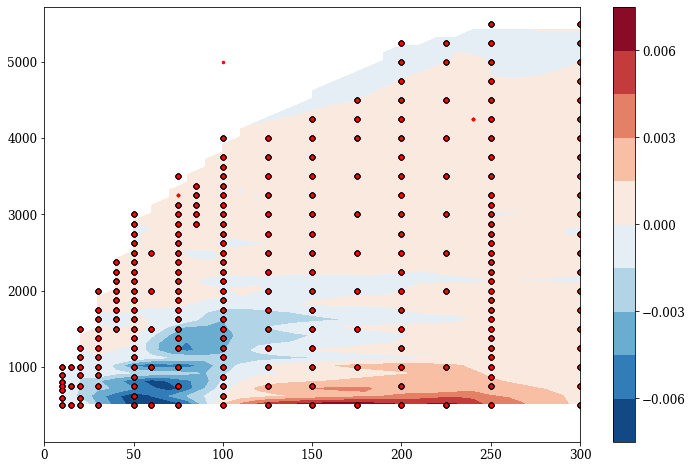

In [28]:
sys_1='Pbcm'
sys_2='fcc'
data = mu_nqe_by_y[sys_1][0.5][:,[2,1,3]]
data_2 = mu_nqe_by_y[sys_2][0.5][:,[2,1,3]]

fig, ax = plt.subplots(figsize=(12,8))

ax.set_xlim([0, 300])

# regular grid covering the domain of the data
X,Y = np.meshgrid(np.arange(10, 700, 10), np.arange(20, 5800, 100))

grid_z1 = griddata(data[:,[0,1]], data[:,2], (X, Y), method='linear')
grid_z2 = griddata(data_2[:,[0,1]], data_2[:,2], (X, Y), method='linear')

cntr1 = ax.contourf(X, Y, grid_z1-grid_z2, levels=11, cmap="RdBu_r")

plt.plot(mu_nqe[sys_1][:,2], mu_nqe[sys_1][:,1], 'k.', ms=10)
plt.plot(mu_nqe[sys_2][:,2], mu_nqe[sys_2][:,1], 'r.', ms=5)

fig.colorbar(cntr1, ax=ax)

0.707107
0.5
0.25
0.707107
0.5
0.25
0.707107
0.5
0.25


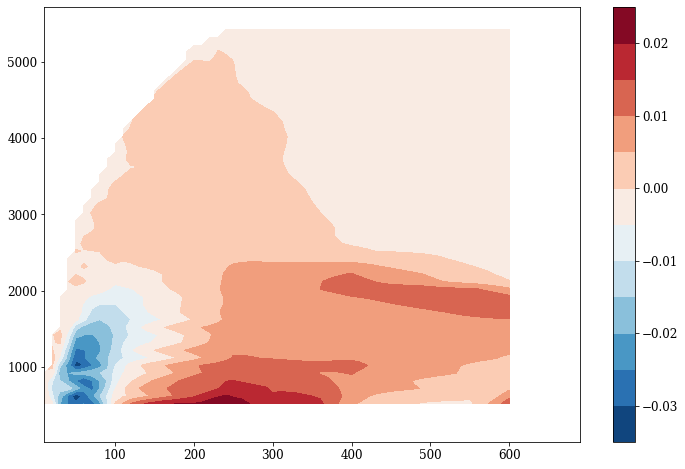

In [29]:
# regular grid covering the domain of the data
X,Y = np.meshgrid(np.arange(10, 700, 10), np.arange(20, 5800, 100))

nqe_on_grid = {}

for s in ['fcc', 'bcc', 'liquid']:
    
    # y = 1
    y = 1
    data = mu_nqe_by_y[s][y][:,[2,1,3]]
    nqe_on_grid[s] = 0.5*(2./y)*(y_list[0]-y_list[1])*griddata(data[:,[0,1]], data[:,2], (X, Y), method='linear')

    for i, y in enumerate(y_list[1:-1]):
        print(y)
        data = mu_nqe_by_y[s][y][:,[2,1,3]]
        grid_z1 = griddata(data[:,[0,1]], data[:,2], (X, Y), method='linear')
        nqe_on_grid[s] = nqe_on_grid[s] + (2./y)*(y_list[i]-y_list[i+1])*grid_z1

fig, ax = plt.subplots(figsize=(12,8))
cntr1 = ax.contourf(X, Y, nqe_on_grid['bcc']-nqe_on_grid['fcc'], levels=11, cmap="RdBu_r")
fig.colorbar(cntr1, ax=ax)

### mu

In [30]:
# read mu
P_list_mu = [50,15,20, 30,70, 90, 100, 110, 125, 150, 175,200]

# T[K] P[GPa] n-n_rstraint raw_mu[eV] error_raw_mu[eV]

mlpmu = {}
mlpmu_by_P = {}

for s in ['bcc', 'X', 'Pbcm']: #,'X','Pbcm']:
    
    mu_raw = np.genfromtxt(sl_dir+'mu-'+s+'.dat')
    mu_raw = np.asarray([ m for m in mu_raw if not isnan(m[-1])])
    mlpmu[s] = np.zeros((len(mu_raw),4))
    
    for i,mu_now in enumerate(mu_raw):
        t_now, p_now = mu_now[0], mu_now[1]
        #avg_solid = griddata(mlpcolvar[s][:,[0,1]], mlpcolvar[s][:,4], (p_now, t_now), method='linear')
        #avg_liquid = griddata(mlpcolvar['liquid'][:,[0,1]], mlpcolvar['liquid'][:,4], (p_now, t_now), method='linear')
        #norm_factor = max(avg_solid - avg_liquid, 0.85)
        #print(t_now, p_now, norm_factor)
        mlpmu[s][i,0] = p_now
        mlpmu[s][i,1] = t_now
        mlpmu[s][i,2] = mu_now[3] #/norm_factor
        mlpmu[s][i,3] = mu_now[4] #/norm_factor

"""bcc and X are the same"""
mlpmu['bcc']= np.vstack((mlpmu['bcc'],mlpmu['X']))
        
for s in ['fcc']:
    
    mu_raw = np.genfromtxt(sl_dir+'mu-'+s+'.dat')
    mu_raw = np.asarray([ m for m in mu_raw if not isnan(m[-1])])
    mlpmu[s] = np.zeros((len(mu_raw),4))
    
    for i,mu_now in enumerate(mu_raw):
        t_now, p_now = mu_now[0], mu_now[1]
        #avg_solid = griddata(mlpcolvar[s][:,[0,1]], mlpcolvar[s][:,2], (p_now, t_now), method='linear')
        #avg_liquid = griddata(mlpcolvar['liquid'][:,[0,1]], mlpcolvar['liquid'][:,2], (p_now, t_now), method='linear')
        #norm_factor = max(avg_solid - avg_liquid, 0.85)
        #print(t_now, p_now, norm_factor)
        mlpmu[s][i,0] = p_now
        mlpmu[s][i,1] = t_now
        mlpmu[s][i,2] = mu_now[3] #/norm_factor
        mlpmu[s][i,3] = mu_now[4] #/norm_factor
        
# seperate by P
mlpmu_by_P = {}

for s in ['bcc','fcc', 'X',  'Pbcm']:
    mlpmu_by_P[s] = {}
    for p in P_list_mu:
        mlpmu_by_P[s][p] = [ mlpmu[s][mlpmu[s][:,0]==p]]

In [31]:
# seperate by P
avg_mlpmu_by_P = {}

for s in ['bcc','fcc', 'X', 'Pbcm']:
    avg_mlpmu_by_P[s] = {}
    for p in P_list_mu:
        mu_tmp_P = np.squeeze(mlpmu_by_P[s][p])
        
        t_list = np.unique(mu_tmp_P[:,1])
        avg_mlpmu_by_P[s][p] = []
        for t in t_list:
            mu_tmp_P_T = mu_tmp_P[mu_tmp_P[:,1]==t]
            #print(mu_tmp_P_T)
            avg_mlpmu_by_P[s][p].append([p, t, np.mean(mu_tmp_P_T[:,2]), np.std(mu_tmp_P_T[:,2])/np.sqrt(len(mu_tmp_P_T)-1)])
        avg_mlpmu_by_P[s][p] = np.asarray(avg_mlpmu_by_P[s][p])

Text(0.5, 0, 'T [$K$]')

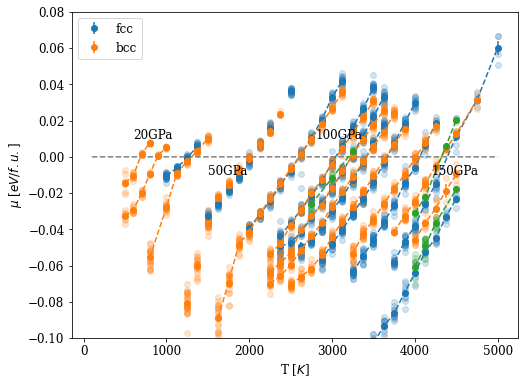

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)

xr = np.arange(100,5000)
ax.plot(xr, xr*0.0, c='gray',ls='--')

for i,sys_now in enumerate(['fcc', 'bcc', 'Pbcm']): #,'X','Pbcm']):

    for j, p in enumerate(P_list_mu):
        mu_tmp = np.squeeze(mlpmu_by_P[sys_now][p])
        mu_tmp = mu_tmp[mu_tmp[:,1].argsort()]
        ax.scatter(mu_tmp[:,1], mu_tmp[:,2],
                    c=cm.tab10(i), marker='o',alpha=0.2,label=None)
        
        mu_avg_tmp = avg_mlpmu_by_P[sys_now][p]
        if j==0 and len(mu_avg_tmp) > 0:
            ax.errorbar(mu_avg_tmp[:,1], mu_avg_tmp[:,2], yerr=mu_avg_tmp[:,3],
                    c=cm.tab10(i), marker='o', label=sys_now,ls='')
        elif len(mu_avg_tmp) > 0:
            ax.errorbar(mu_avg_tmp[:,1], mu_avg_tmp[:,2], yerr=mu_avg_tmp[:,3],
                    c=cm.tab10(i), marker='o',ls='--')    

ax.text(600,0.01,'20GPa')
ax.text(1500,-0.01,'50GPa')  
ax.text(2800,0.01,'100GPa')  
ax.text(4200,-0.01,'150GPa')  

ax.legend()
ax.set_ylim([-0.1, 0.08])
ax.set_ylabel('$\mu$ [$eV/f.u.$]')
ax.set_xlabel("T [$K$]")

Text(0.5, 0, 'T [$K$]')

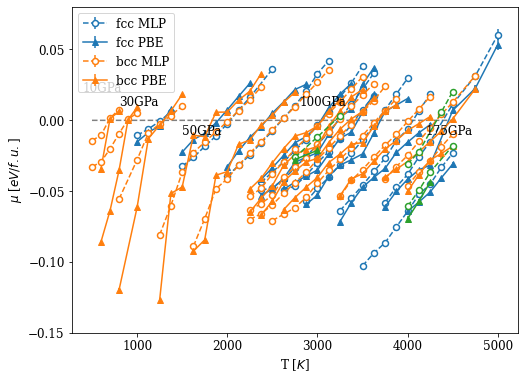

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)

xr = np.arange(500,4500)
ax.plot(xr, xr*0.0, c='gray',ls='--')

for i,sys_now in enumerate(['fcc','bcc','Pbcm']):

    for j, p in enumerate(P_list_mu):
        mu_tmp = np.squeeze(avg_mlpmu_by_P[sys_now][p])
        if len(mu_tmp) < 2: continue
        mu_tmp = mu_tmp[mu_tmp[:,1].argsort()]
        if j==0:
            l_now = sys_now+' MLP'
        else:
            l_now = None
        ax.errorbar(mu_tmp[:,1], mu_tmp[:,2], yerr=mu_tmp[:,3],
                    c=cm.tab10(i), marker='o',
                    markerfacecolor='w', markeredgewidth=1.5, markeredgecolor=cm.tab10(i),
                    ls='--',alpha=1., label=l_now) 
        
        # add the mu_DFT - mu_NNP correction term
        if sys_now == 'X':
            data = mu_nnp2dft['bcc'][:,[0,1,2]]
        else:
            data = mu_nnp2dft[sys_now][:,[0,1,2]]
        data_ref = mu_nnp2dft['liquid'][:,[0,1,2]]
        
        if j==0:
            l_now = sys_now+' PBE'
        else:
            l_now = None
            
        # regular grid covering the domain of the data
        dmu_nnp2dft_now = griddata(data[:,[0,1]], data[:,2], (p, mu_tmp[:,1]), method='linear')
        dmu_nnp2dft_ref = griddata(data_ref[:,[0,1]], data_ref[:,2], (p, mu_tmp[:,1]), method='linear')
        
        ax.errorbar(mu_tmp[:,1], mu_tmp[:,2]+dmu_nnp2dft_now-dmu_nnp2dft_ref, yerr=mu_tmp[:,3],
                    c=cm.tab10(i), marker='^',ls='-',label=l_now)

ax.text(400,0.02,'10GPa')
ax.text(800,0.01,'30GPa')
ax.text(1500,-0.01,'50GPa')  
ax.text(2800,0.01,'100GPa')  
ax.text(4200,-0.01,'175GPa')  

ax.legend()
ax.set_ylim([-0.15, 0.08])
ax.set_ylabel('$\mu$ [$eV/f.u.$]')
ax.set_xlabel("T [$K$]")



# process mu

#### analyze dmu_ice - dmu_liquid

In [34]:
mu_ti = {}

sys_ref = 'liquid'

for i,sys_now in enumerate(['fcc','bcc','Pbcm']):
#for i,sys_now in enumerate(['fcc','bcc','Pbcm-8']): #,'X','Pbcm']):
    
    mu_ti[sys_now] = {}
    
    for j, p in enumerate(P_list_mu):
        mu_tmp = np.squeeze(avg_mlpmu_by_P[sys_now][p])
        if len(mu_tmp.shape) < 2: continue
        mu_tmp = mu_tmp[mu_tmp[:,1].argsort()]
        
        mu_ti[sys_now][p] = np.zeros((len(mu_tmp)+1,2))
        #print(sys_now, p, mu_tmp)
        #tmean = np.mean(mu_tmp[:,1])
        fit_tmp = np.polyfit(mu_tmp[:,1], mu_tmp[:,2], 1)
        tmean = -fit_tmp[1]/fit_tmp[0]
        print("initial est:", tmean)
        tm_est_list = []
        for tm_est in np.arange(tmean-100, tmean+100, 5):
            error = 0.0
            n_error = 0
            for mu_now in mu_tmp:
                t = mu_now[1]
                try:
                    mu_est = t*get_dmu_TdT(mlpeos[sys_now][:,[0,1,2,4]], p, tm_est, t)- \
                             t*get_dmu_TdT(mlpeos[sys_ref][:,[0,1,2,4]], p, tm_est, t)
                except:
                    continue
                if not isnan(mu_est): 
                    error += (mu_now[2] - mu_est)**2.
                    n_error += 1
                #print(tm_est, t, mu_now[2], mu_est)
            if n_error > 0:
                tm_est_list.append([tm_est, error/n_error])
        #print(sys_now, p, tm_est_list)
        tm_est_list = np.asarray(tm_est_list)
        if len(tm_est_list) > 1:
            tm_best = tm_est_list[tm_est_list[:,1].argsort()][0][0]
            print(sys_now, p, tm_best)
            mu_ti[sys_now][p][0] = [tm_best, 0.0]
        for i, mu_now in enumerate(mu_tmp):
            t = mu_now[1]
            try:
                mu_est = t*get_dmu_TdT(mlpeos[sys_now][:,[0,1,2,4]], p, tm_best, t)- \
                        t*get_dmu_TdT(mlpeos[sys_ref][:,[0,1,2,4]], p, tm_best, t)
            except:
                continue
            mu_ti[sys_now][p][i+1] = [t, mu_est]

initial est: 2009.3044541859476
fcc 50 2024.3044541859476
initial est: 1251.9493831174086
fcc 30 1261.9493831174086
initial est: 2578.5299633753116
fcc 70 2598.5299633753116
initial est: 3020.4583851031457
fcc 90 3045.4583851031457
initial est: 3206.4344027637503
fcc 100 3231.4344027637503
initial est: 3410.8680510532904
fcc 110 3420.8680510532904
initial est: 3649.1480067414723
fcc 125 3669.1480067414723
initial est: 4052.3751562167745
fcc 150 4062.3751562167745
initial est: 4388.918625045362
fcc 175 4403.918625045362
initial est: 4792.100266319531
fcc 200 4727.100266319531
initial est: 2024.153018154088
bcc 50 2029.153018154088
initial est: 699.9934828263813
bcc 15 704.9934828263813
initial est: 921.6414235939649
bcc 20 886.6414235939649
initial est: 1322.1482596631781
bcc 30 1327.1482596631781
initial est: 2609.998188108735
bcc 70 2614.998188108735
initial est: 3054.309805574355
bcc 90 3069.309805574355
initial est: 3241.9233129923155
bcc 100 3256.9233129923155
initial est: 3415.255

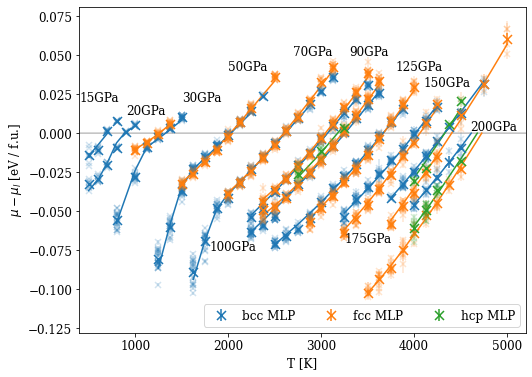

In [35]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)

xr = np.arange(100,6000)
ax.plot(xr, xr*0.0, c='gray',ls='-',alpha=0.5)

for i,sys_now in enumerate(['bcc','fcc','Pbcm']): #,'Pbcm']):

    for j, p in enumerate([ 100,50, 15, 20, 30, 70, 90,125, 150, 175,200]):
        
        # individual interface pinning results
        mu_tmp = np.squeeze(mlpmu_by_P[sys_now][p])
        if len(mu_tmp.shape) < 2: continue
        mu_tmp = mu_tmp[mu_tmp[:,1].argsort()]
        ax.errorbar(mu_tmp[:,1], mu_tmp[:,2], yerr=mu_tmp[:,3],
                    c=cm.tab10(i), marker='x', 
                    markerfacecolor='w', markeredgewidth=1.5, markeredgecolor=cm.tab10(i),
                    ls='',alpha=0.2)  

        # avg interface pinning results
        mu_tmp = np.squeeze(avg_mlpmu_by_P[sys_now][p])
        if len(mu_tmp.shape) < 2: continue
        mu_tmp = mu_tmp[mu_tmp[:,1].argsort()]
        if j == 0: 
            l_now = acronym[sys_now]+' MLP'
        else:
            l_now = None
        ax.errorbar(mu_tmp[:,1], mu_tmp[:,2], yerr=mu_tmp[:,3],
                    c=cm.tab10(i), marker='x', ms=9,
                    markerfacecolor='w', markeredgewidth=1.5, markeredgecolor=cm.tab10(i),
                    label=l_now,ls='')  
        
        # TI results
        if p not in mu_ti[sys_now] or len(mu_ti[sys_now][p].shape) < 2: continue
        mu_ti_tmp = mu_ti[sys_now][p]
        mu_ti_tmp = mu_ti_tmp[mu_ti_tmp[:,1].argsort()]
        ax.plot(mu_ti_tmp[:,0], mu_ti_tmp[:,1], c=cm.tab10(i), ls='-')
                        
        
ax.text(400,0.02,'15GPa')
ax.text(900,0.012,'20GPa')
ax.text(1500,0.02,'30GPa')
ax.text(2000,0.04,'50GPa')
ax.text(2700,0.05,'70GPa')
ax.text(3300,0.05,'90GPa')
ax.text(1800,-0.075,'100GPa')
#ax.text(1800,-0.085,'110GPa')
ax.text(3800,0.04,'125GPa')
ax.text(4100,0.03,'150GPa')
ax.text(3250,-0.07,'175GPa')
ax.text(4600,0.002,'200GPa')

ax.legend(loc='lower right', ncol=3)
ax.set_xlim([400, 5200])
#ax.set_ylim([4, 20])
ax.set_ylabel('$\mu-\mu_{l}$ [eV / f.u.]')
ax.set_xlabel("T [K]")

fig.savefig("mu_ref_liquid_nnp.pdf", dpi=300,bbox_inches='tight')

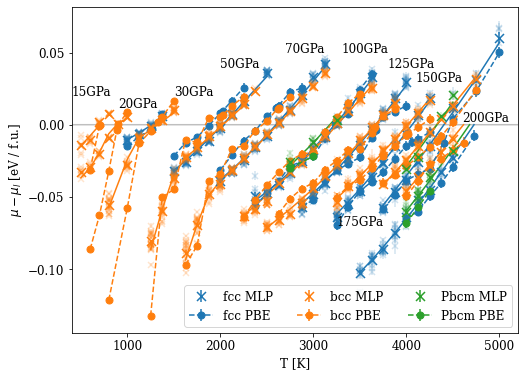

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)

xr = np.arange(100,6000)
ax.plot(xr, xr*0.0, c='gray',ls='-',alpha=0.5)

for i,sys_now in enumerate(['fcc','bcc','Pbcm']):

    for j, p in enumerate([100,50,15,20, 30,70,  125, 150, 175,200]):
        
        # individual interface pinning results
        mu_tmp = np.squeeze(mlpmu_by_P[sys_now][p])
        if len(mu_tmp) < 2: continue
        mu_tmp = mu_tmp[mu_tmp[:,1].argsort()]
        ax.errorbar(mu_tmp[:,1], mu_tmp[:,2], yerr=mu_tmp[:,3],
                    c=cm.tab10(i), marker='x', 
                    markerfacecolor='w', markeredgewidth=1.5, markeredgecolor=cm.tab10(i),
                    ls='',alpha=0.2)  

        # avg interface pinning results
        mu_tmp = np.squeeze(avg_mlpmu_by_P[sys_now][p])
        if len(mu_tmp.shape) < 2: continue
        mu_tmp = mu_tmp[mu_tmp[:,1].argsort()]
        if j == 0: 
            l_now = sys_now+' MLP'
        else:
            l_now = None
        ax.errorbar(mu_tmp[:,1], mu_tmp[:,2], yerr=mu_tmp[:,3],
                    c=cm.tab10(i), marker='x', ms=9,
                    markerfacecolor='w', markeredgewidth=1.5, markeredgecolor=cm.tab10(i),
                    label=l_now,ls='')  
        
        # TI results
        if p in mu_ti[sys_now] and len(mu_ti[sys_now][p]) > 2:
            mu_ti_tmp = mu_ti[sys_now][p]
            mu_ti_tmp = mu_ti_tmp[mu_ti_tmp[:,1].argsort()]
            ax.plot(mu_ti_tmp[:,0], mu_ti_tmp[:,1], c=cm.tab10(i), ls='-')
            
            
            
        # add the mu_DFT - mu_NNP correction term
        
        if j == 0: 
            l_now = sys_now + ' PBE'
        else:
            l_now = None
            
        data = mu_nnp2dft[sys_now][:,[0,1,2,3]]
        data_ref = mu_nnp2dft['liquid'][:,[0,1,2,3]]
        # regular grid covering the domain of the data
        dmu_nnp2dft_now = griddata(data[:,[0,1]], data[:,2], (p, mu_ti_tmp[:,0]), method='linear')
        dmu_nnp2dft_ref = griddata(data_ref[:,[0,1]], data_ref[:,2], (p, mu_ti_tmp[:,0]), method='linear')
        dmu_nnp2dft_now_error = griddata(data[:,[0,1]], data[:,3], (p, mu_ti_tmp[:,0]), method='linear')
        dmu_nnp2dft_ref_error = griddata(data_ref[:,[0,1]], data_ref[:,3], (p, mu_ti_tmp[:,0]), method='linear')
        
        ax.errorbar(mu_ti_tmp[:,0], mu_ti_tmp[:,1]+dmu_nnp2dft_now-dmu_nnp2dft_ref, 
                    yerr=np.sqrt(dmu_nnp2dft_now_error**2.+dmu_nnp2dft_ref_error**2.),
                    c=cm.tab10(i), marker='o', ms=7,
                    #markerfacecolor='none', markeredgewidth=1.5,
                    ls='--', label=l_now)
        
ax.text(400,0.02,'15GPa')
ax.text(900,0.012,'20GPa')
ax.text(1500,0.02,'30GPa')
ax.text(2000,0.04,'50GPa')
ax.text(2700,0.05,'70GPa')
ax.text(3300,0.05,'100GPa')
#ax.text(1700,-0.07,'100GPa')
#ax.text(1800,-0.085,'110GPa')
ax.text(3800,0.04,'125GPa')
ax.text(4100,0.03,'150GPa')
ax.text(3250,-0.07,'175GPa')
ax.text(4600,0.002,'200GPa')

ax.legend(loc='lower right', ncol=3)
ax.set_xlim([400, 5200])
#ax.set_ylim([4, 20])
ax.set_ylabel('$\mu-\mu_{l}$ [eV / f.u.]')
ax.set_xlabel("T [K]")

fig.savefig("mu_ref_liquid_classical.pdf", dpi=300,bbox_inches='tight')

Text(0.5, 0, 'T [K]')

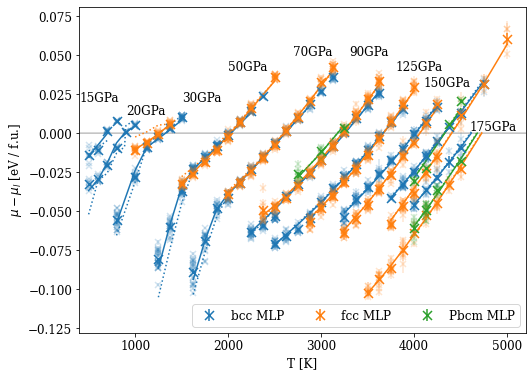

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)

xr = np.arange(100,6000)
ax.plot(xr, xr*0.0, c='gray',ls='-',alpha=0.5)

for i,sys_now in enumerate(['bcc','fcc','Pbcm']): #,]):

    for j, p in enumerate([ 100, 15, 20, 30, 70, 50, 125, 150, 175,200]):
        
        # individual interface pinning results
        mu_tmp = np.squeeze(mlpmu_by_P[sys_now][p])
        if len(mu_tmp.shape) < 2: continue
        mu_tmp = mu_tmp[mu_tmp[:,1].argsort()]
        ax.errorbar(mu_tmp[:,1], mu_tmp[:,2], yerr=mu_tmp[:,3],
                    c=cm.tab10(i), marker='x', 
                    markerfacecolor='w', markeredgewidth=1.5, markeredgecolor=cm.tab10(i),
                    ls='',alpha=0.2)  

        # avg interface pinning results
        mu_tmp = np.squeeze(avg_mlpmu_by_P[sys_now][p])
        if len(mu_tmp.shape) < 2: continue
        mu_tmp = mu_tmp[mu_tmp[:,1].argsort()]
        if j == 0: 
            l_now = sys_now+' MLP'
        else:
            l_now = None
        ax.errorbar(mu_tmp[:,1], mu_tmp[:,2], yerr=mu_tmp[:,3],
                    c=cm.tab10(i), marker='x', ms=9,
                    markerfacecolor='w', markeredgewidth=1.5, markeredgecolor=cm.tab10(i),
                    label=l_now,ls='')  
        
        # TI results
        if p in mu_ti[sys_now] and len(mu_ti[sys_now][p]) < 2: continue
        mu_ti_tmp = mu_ti[sys_now][p]
        mu_ti_tmp = mu_ti_tmp[mu_ti_tmp[:,1].argsort()]
        ax.plot(mu_ti_tmp[:,0], mu_ti_tmp[:,1], c=cm.tab10(i), ls='-')
                        
        # add NQEs
        y = 1
        data = mu_nqe_by_y[sys_now][y][:,[2,1,3]]
        nqe_on_grid = 0.5*(2./y)*(y_list[0]-y_list[1])*\
            griddata(data[:,[0,1]], data[:,2], 
                     (p, mu_ti_tmp[:,0]), method='linear')

        data_ref = mu_nqe_by_y['liquid'][y][:,[2,1,3]]
        nqe_on_grid_ref = 0.5*(2./y)*(y_list[0]-y_list[1])*\
            griddata(data_ref[:,[0,1]], data_ref[:,2], 
                     (p, mu_ti_tmp[:,0]), method='linear')
        
        for yi, y in enumerate(y_list[1:-1]):
            data = mu_nqe_by_y[sys_now][y][:,[2,1,3]]
            grid_z1 = griddata(data[:,[0,1]], data[:,2], (p, mu_ti_tmp[:,0]), method='linear')
            nqe_on_grid = nqe_on_grid + (2./y)*(y_list[yi]-y_list[yi+1])*grid_z1
            
            data_ref = mu_nqe_by_y['liquid'][y][:,[2,1,3]]
            grid_z1 = griddata(data_ref[:,[0,1]], data_ref[:,2], 
                               (p, mu_ti_tmp[:,0]), method='linear')
            nqe_on_grid_ref = nqe_on_grid_ref + (2./y)*(y_list[yi]-y_list[yi+1])*grid_z1
            
            
        ax.plot(mu_ti_tmp[:,0], mu_ti_tmp[:,1]+nqe_on_grid-nqe_on_grid_ref, c=cm.tab10(i), ls='dotted')
            
        # add the mu_DFT - mu_NNP correction term
        """
        if j == 0: 
            l_now = sys_now + ' PBE'
        else:
            l_now = None
            
        data = mu_nnp2dft[sys_now][:,[0,1,2,3]]
        data_ref = mu_nnp2dft['liquid'][:,[0,1,2,3]]
        # regular grid covering the domain of the data
        dmu_nnp2dft_now = griddata(data[:,[0,1]], data[:,2], (p, mu_ti_tmp[:,0]), method='linear')
        dmu_nnp2dft_ref = griddata(data_ref[:,[0,1]], data_ref[:,2], (p, mu_ti_tmp[:,0]), method='linear')
        dmu_nnp2dft_now_error = griddata(data[:,[0,1]], data[:,3], (p, mu_ti_tmp[:,0]), method='linear')
        dmu_nnp2dft_ref_error = griddata(data_ref[:,[0,1]], data_ref[:,3], (p, mu_ti_tmp[:,0]), method='linear')
        
        ax.errorbar(mu_ti_tmp[:,0], mu_ti_tmp[:,1]+dmu_nnp2dft_now-dmu_nnp2dft_ref, 
                    yerr=np.sqrt(dmu_nnp2dft_now_error**2.+dmu_nnp2dft_ref_error**2.),
                    c=cm.tab10(i+2), marker='o', ms=7,
                    #markerfacecolor='none', markeredgewidth=1.5,
                    ls='--', label=l_now)
        """
        
ax.text(400,0.02,'15GPa')
ax.text(900,0.012,'20GPa')
ax.text(1500,0.02,'30GPa')
ax.text(2000,0.04,'50GPa')
ax.text(2700,0.05,'70GPa')
ax.text(3300,0.05,'90GPa')
#ax.text(1700,-0.07,'100GPa')
#ax.text(1800,-0.085,'110GPa')
ax.text(3800,0.04,'125GPa')
ax.text(4100,0.03,'150GPa')
ax.text(4600,0.002,'175GPa')

ax.legend(loc='lower right', ncol=3)
ax.set_xlim([400, 5200])
#ax.set_ylim([4, 20])
ax.set_ylabel('$\mu-\mu_{l}$ [eV / f.u.]')
ax.set_xlabel("T [K]")

#fig.savefig("mu_ref_liquid_nnp_nqe.pdf", dpi=300)

In [38]:
# compute t_m at the DFT level
tm_dft = {}


for sys_now in ['bcc', 'fcc', 'Pbcm']:
    tm_dft[sys_now] = {}
    
    for p in P_list_mu:
                
        if p not in mu_ti[sys_now] or len(mu_ti[sys_now][p]) < 2: continue
        tm_now = mu_ti[sys_now][p][0,0]

        mu_tmp = np.squeeze(mu_ti[sys_now][p])
        if len(mu_tmp) < 2: continue
            
        mu_tmp = mu_tmp[np.abs(mu_tmp[:,0]-tm_now).argsort()][0:2]
        #print(mu_tmp)
        fit_tmp = np.polyfit(mu_tmp[:,0], mu_tmp[:,1], 1)
        dmu_dT_at_Tm = fit_tmp[0]

        data = mu_nnp2dft[sys_now][:,[0,1,2,3]]
        data_ref = mu_nnp2dft['liquid'][:,[0,1,2,3]]
        dmu_nnp2dft_now = griddata(data[:,[0,1]], data[:,2], (p, tm_now), method='linear')
        dmu_nnp2dft_ref = griddata(data_ref[:,[0,1]], data_ref[:,2], (p, tm_now), method='linear')

        dT = (dmu_nnp2dft_now-dmu_nnp2dft_ref)/dmu_dT_at_Tm

        print(sys_now, p, dT, "MLP:", tm_now, "DFT:", tm_now-dT)
        
        tm_dft[sys_now][p] = tm_now-dT
        

bcc 50 118.13741672449352 MLP: 2029.153018154088 DFT: 1911.0156014295944
bcc 15 -7.760492497792224 MLP: 704.9934828263813 DFT: 712.7539753241736
bcc 20 -83.22293574278099 MLP: 886.6414235939649 DFT: 969.8643593367459
bcc 30 34.370746678487784 MLP: 1327.1482596631781 DFT: 1292.7775129846902
bcc 70 166.23502552523198 MLP: 2614.998188108735 DFT: 2448.7631625835033
bcc 90 -1.4466401394784978 MLP: 3069.309805574355 DFT: 3070.7564457138333
bcc 100 76.11369831738034 MLP: 3256.9233129923155 DFT: 3180.809614674935
bcc 110 30.402343976434196 MLP: 3420.255976870641 DFT: 3389.853632894207
bcc 125 -25.72765384091616 MLP: 3667.245603946615 DFT: 3692.973257787531
bcc 150 -91.18884645287885 MLP: 4013.5128772377343 DFT: 4104.701723690613
bcc 175 -147.8880973943427 MLP: 4327.884284099303 DFT: 4475.772381493645
bcc 200 -153.9725346101515 MLP: 4614.326163685868 DFT: 4768.298698296019
fcc 50 142.1903174670993 MLP: 2024.3044541859476 DFT: 1882.1141367188484
fcc 30 -56.18836283158249 MLP: 1261.9493831174086 

### analyze dmu_bcc - dmu_fcc

In [39]:
mu_ti_ref_fcc = {}

sys_ref = 'fcc'

for i,sys_now in enumerate(['bcc', 'Pbcm']): #
    
    mu_ti_ref_fcc[sys_now] = {}
    
    for j, p in enumerate(P_list_mu):
        if p not in avg_mlpmu_by_P['fcc'] or p not in avg_mlpmu_by_P[sys_now]:
            continue
        mu_tmp = np.squeeze(avg_mlpmu_by_P[sys_now][p])
        #print(sys_now, p, mu_tmp)
        if len(mu_tmp.shape) < 2: continue            
        mu_ref = np.squeeze(avg_mlpmu_by_P['fcc'][p])
        if len(mu_ref.shape) < 2: continue

        mu_ref = np.asarray([ m for m in mu_ref if m[1] in mu_tmp[:,1]])
        mu_tmp = np.asarray([ m for m in mu_tmp if m[1] in mu_ref[:,1]])
        
        mu_ref = mu_ref[mu_ref[:,1].argsort()]
        mu_tmp = mu_tmp[mu_tmp[:,1].argsort()]
        #print(mu_tmp)
        #print(mu_ref)
        
        mu_dif = mu_tmp - mu_ref
        mu_dif[:,1] = mu_tmp[:,1]
        
        mu_dif_abs = np.abs(mu_tmp[:,2]-mu_ref[:,2])        
        start_T = mu_tmp[mu_dif_abs.argsort()][0,1]
        start_dmu = mu_dif_abs[mu_dif_abs.argsort()][0]
        
        print("initial point:", start_T, start_dmu)
        
        dmu_est_list = np.arange(start_dmu-0.005, start_dmu+0.005, 0.0005)
        dmu_est_list_results = np.zeros((len(dmu_est_list),2))
        for mu_now in mu_dif:
            t = mu_now[1]
            try:
                mu_est = t*get_dmu_TdT(mlpeos[sys_now][:,[0,1,2,4]], p, start_T, t)- \
                             t*get_dmu_TdT(mlpeos[sys_ref][:,[0,1,2,4]], p, start_T, t)
            except:
                continue

            if not isnan(mu_est): 
                for i,dmu_est in enumerate(dmu_est_list):
                    dmu_est_list_results[i,0] += (mu_now[2] - mu_est - dmu_est)**2.
                    dmu_est_list_results[i,1] += 1
        
        for i,dmu_est in enumerate(dmu_est_list):
            if dmu_est_list_results[i,1] >= 1:
                dmu_est_list_results[i,0] /= dmu_est_list_results[i,1]
            else:
                dmu_est_list_results[i,0] = 1e20
        
        #print(dmu_est_list_results)
        dmu_best = dmu_est_list[dmu_est_list_results[:,0].argsort()][0]
        
        print(sys_now, p, dmu_best)
        
        t_list =np.arange(min(start_T-1500,1000), max(start_T+2000,5000), 20)
        mu_ti_ref_fcc[sys_now][p] = np.zeros((len(t_list)+1,2))
        mu_ti_ref_fcc[sys_now][p][0] = [start_T, start_dmu]
        for i, t in enumerate(t_list):
            try:
                mu_est = t*get_dmu_TdT(mlpeos[sys_now][:,[0,1,2,4]], p, start_T, t)- \
                        t*get_dmu_TdT(mlpeos[sys_ref][:,[0,1,2,4]], p, start_T, t) \
                      + dmu_best
            except:
                continue
            
            mu_ti_ref_fcc[sys_now][p][i+1] = [t, mu_est]

initial point: 2125.0 0.00021331708333333348
bcc 50 -0.0002866829166666626
initial point: 1250.0 0.0017836950999999997
bcc 30 -0.0032163049000000004
initial point: 2125.0 0.00013929343434344182
bcc 70 0.0001392934343434375
initial point: 2625.0 6.183479853480098e-05
bcc 90 -0.0009381652014652025
initial point: 3125.0 0.00021317454545454438
bcc 100 -0.0017868254545454583
initial point: 3375.0 7.771626818181814e-05
bcc 110 7.771626818182248e-05
initial point: 3750.0 0.0006463231666666647
bcc 125 0.00014632316666666513
initial point: 4125.0 0.0012581378571428587
bcc 150 0.003258137857142859
initial point: 4750.0 0.00023932000000000814
bcc 175 0.0017393200000000025
initial point: 4500.0 0.013472302857142857
bcc 200 0.01147230285714286
initial point: 3250.0 0.0017779190391304354
Pbcm 100 0.004777919039130435
initial point: 4125.0 0.003567158333333334
Pbcm 175 0.006567158333333334
initial point: 4125.0 0.002948199999999998
Pbcm 200 0.005448199999999998


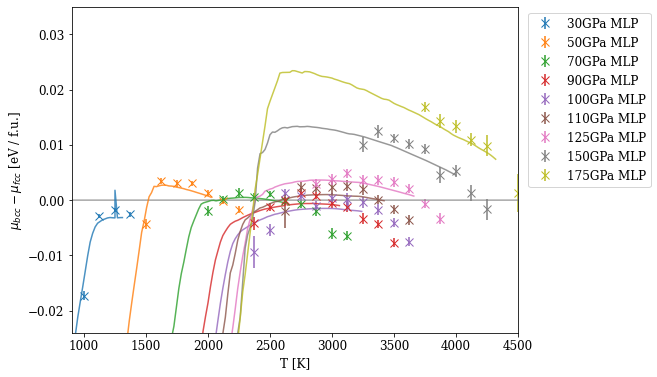

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)

xr = np.arange(100,5000)
ax.plot(xr, xr*0.0, c='gray',ls='-',alpha=0.7)

for i,sys_now in enumerate(['bcc']):
    #for j, p in enumerate([50,100, 175]): #P_list_mu):
    for j, p in enumerate([30, 50, 70,90,100, 110,125,150,175]): #P_list_mu):
        
        
        # draw the vertical Tm lines
        if p in mu_ti[sys_now] and len(mu_ti[sys_now][p]) > 0:
            tm_now_mlp = mu_ti[sys_now][p][0,0]
            #ax.axvline(tm_now, c=cm.tab10(j), ls='-',alpha=0.3)
            #ax.text(tm_now-200,-0.015+0.003*(j%3),
            #        'T$_m$('+str(p)+")",c=cm.tab10(j),weight="bold")

        
        #""" plot the TI curves        
        if p in mu_ti_ref_fcc[sys_now] and len(mu_ti_ref_fcc[sys_now][p]) > 2:
            mu_ti_tmp = np.asarray([ m for m in mu_ti_ref_fcc[sys_now][p] if m[0] < tm_now_mlp and not isnan(m[1]) ])
            
            mu_ti_tmp = mu_ti_tmp[mu_ti_tmp[:,0].argsort()] 
            
            ax.plot(mu_ti_tmp[:,0], mu_ti_tmp[:,1], c=cm.tab10(j), alpha=0.8, ls='-')
        #"""            
        
        mu_tmp = np.squeeze(avg_mlpmu_by_P[sys_now][p])
        #print(sys_now, p, mu_tmp)
        if len(mu_tmp) < 2: continue            
        mu_ref = np.squeeze(avg_mlpmu_by_P['fcc'][p])
        
        mu_ref = np.asarray([ m for m in mu_ref if m[1] in mu_tmp[:,1]])
        mu_tmp = np.asarray([ m for m in mu_tmp if m[1] in mu_ref[:,1]])
        
        mu_ref = mu_ref[mu_ref[:,1].argsort()]
        mu_tmp = mu_tmp[mu_tmp[:,1].argsort()]
        
        
        ax.errorbar(mu_tmp[:,1], mu_tmp[:,2]-mu_ref[:,2], yerr=mu_tmp[:,3]+mu_ref[:,3],
                    c=cm.tab10(j), marker='x', ms=8, label=str(p)+'GPa MLP',ls='')
        
        # add the mu_DFT - mu_NNP correction term
        """
        data = mu_nnp2dft[sys_now][:,[0,1,2,3]]
        data_ref = mu_nnp2dft['fcc'][:,[0,1,2,3]]
        
        
        # regular grid covering the domain of the data
        dmu_nnp2dft_now = griddata(data[:,[0,1]], data[:,2], (p, mu_tmp[:,1]), method='linear')
        dmu_nnp2dft_ref = griddata(data_ref[:,[0,1]], data_ref[:,2], (p, mu_tmp[:,1]), method='linear')
        dmu_nnp2dft_now_error = griddata(data[:,[0,1]], data[:,3], (p, mu_tmp[:,1]), method='linear')
        dmu_nnp2dft_ref_error = griddata(data_ref[:,[0,1]], data_ref[:,3], (p, mu_tmp[:,1]), method='linear')
        # add on raw data
        ax.errorbar(mu_tmp[:,1], mu_tmp[:,2]-mu_ref[:,2]+dmu_nnp2dft_now-dmu_nnp2dft_ref, 
                    yerr=np.sqrt(mu_tmp[:,3]**2.+dmu_nnp2dft_now_error**2.+dmu_nnp2dft_ref_error**2.),
                    c=cm.tab10(j), marker='^',ls='-')
        
        
        # add on ti data 
        # regular grid covering the domain of the data
        dmu_nnp2dft_now = griddata(data[:,[0,1]], data[:,2], (p, mu_ti_tmp[:,0]), method='linear')
        dmu_nnp2dft_ref = griddata(data_ref[:,[0,1]], data_ref[:,2], (p, mu_ti_tmp[:,0]), method='linear')
        dmu_nnp2dft_now_error = griddata(data[:,[0,1]], data[:,3], (p, mu_ti_tmp[:,0]), method='linear')
        dmu_nnp2dft_ref_error = griddata(data_ref[:,[0,1]], data_ref[:,3], (p, mu_ti_tmp[:,0]), method='linear')
        ax.errorbar(mu_ti_tmp[:,0], mu_ti_tmp[:,1]+dmu_nnp2dft_now-dmu_nnp2dft_ref, 
                    yerr=np.sqrt(dmu_nnp2dft_now_error**2.+dmu_nnp2dft_ref_error**2.),
                    c=cm.tab10(j), marker='^',ls='--')
        """


ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_xlim([900, 4500])
ax.set_ylim([-0.024,0.035])
ax.set_ylabel('$\mu_{bcc} - \mu_{fcc}$ [eV / f.u.]')
ax.set_xlabel("T [K]")

fig.savefig("mu_ref_fcc.pdf", dpi=300)

Text(0.5, 0, 'T [K]')

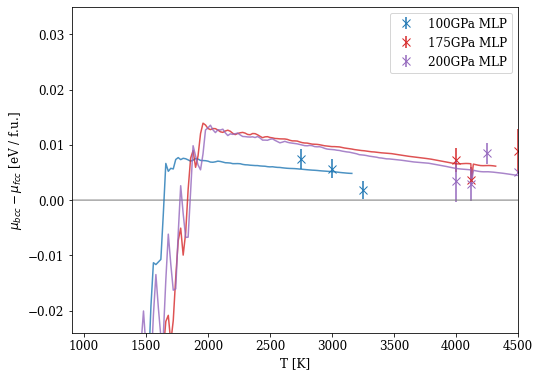

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)

xr = np.arange(100,5000)
ax.plot(xr, xr*0.0, c='gray',ls='-',alpha=0.7)

for i,sys_now in enumerate(['Pbcm']):
    #for j, p in enumerate([50,100, 175]): #P_list_mu):
    for j, p in enumerate([100,125,150,175,200]): #P_list_mu):
        
        
        # draw the vertical Tm lines
        if p in mu_ti[sys_now] and len(mu_ti[sys_now][p]) > 0:
            tm_now_mlp = mu_ti[sys_now][p][0,0]
            #ax.axvline(tm_now, c=cm.tab10(j), ls='-',alpha=0.3)
            #ax.text(tm_now-200,-0.015+0.003*(j%3),
            #        'T$_m$('+str(p)+")",c=cm.tab10(j),weight="bold")

        
        #""" plot the TI curves        
        if p in mu_ti_ref_fcc[sys_now] and len(mu_ti_ref_fcc[sys_now][p]) > 2:
            mu_ti_tmp = np.asarray([ m for m in mu_ti_ref_fcc[sys_now][p] if m[0] < tm_now_mlp and not isnan(m[1]) ])
            
            mu_ti_tmp = mu_ti_tmp[mu_ti_tmp[:,0].argsort()] 
            
            ax.plot(mu_ti_tmp[:,0], mu_ti_tmp[:,1], c=cm.tab10(j), alpha=0.8, ls='-')
        #"""            
        
        mu_tmp = np.squeeze(avg_mlpmu_by_P[sys_now][p])
        #print(sys_now, p, mu_tmp)
        if len(mu_tmp.shape) < 2: continue            
        mu_ref = np.squeeze(avg_mlpmu_by_P['fcc'][p])
        
        mu_ref = np.asarray([ m for m in mu_ref if m[1] in mu_tmp[:,1]])
        mu_tmp = np.asarray([ m for m in mu_tmp if m[1] in mu_ref[:,1]])
        
        mu_ref = mu_ref[mu_ref[:,1].argsort()]
        mu_tmp = mu_tmp[mu_tmp[:,1].argsort()]
        
        
        ax.errorbar(mu_tmp[:,1], mu_tmp[:,2]-mu_ref[:,2], yerr=mu_tmp[:,3]+mu_ref[:,3],
                    c=cm.tab10(j), marker='x', ms=8, label=str(p)+'GPa MLP',ls='')
        
        # add the mu_DFT - mu_NNP correction term
        """
        data = mu_nnp2dft[sys_now][:,[0,1,2,3]]
        data_ref = mu_nnp2dft['fcc'][:,[0,1,2,3]]
        
        
        # regular grid covering the domain of the data
        dmu_nnp2dft_now = griddata(data[:,[0,1]], data[:,2], (p, mu_tmp[:,1]), method='linear')
        dmu_nnp2dft_ref = griddata(data_ref[:,[0,1]], data_ref[:,2], (p, mu_tmp[:,1]), method='linear')
        dmu_nnp2dft_now_error = griddata(data[:,[0,1]], data[:,3], (p, mu_tmp[:,1]), method='linear')
        dmu_nnp2dft_ref_error = griddata(data_ref[:,[0,1]], data_ref[:,3], (p, mu_tmp[:,1]), method='linear')
        # add on raw data
        ax.errorbar(mu_tmp[:,1], mu_tmp[:,2]-mu_ref[:,2]+dmu_nnp2dft_now-dmu_nnp2dft_ref, 
                    yerr=np.sqrt(mu_tmp[:,3]**2.+dmu_nnp2dft_now_error**2.+dmu_nnp2dft_ref_error**2.),
                    c=cm.tab10(j), marker='^',ls='-')
        
        
        # add on ti data 
        # regular grid covering the domain of the data
        dmu_nnp2dft_now = griddata(data[:,[0,1]], data[:,2], (p, mu_ti_tmp[:,0]), method='linear')
        dmu_nnp2dft_ref = griddata(data_ref[:,[0,1]], data_ref[:,2], (p, mu_ti_tmp[:,0]), method='linear')
        dmu_nnp2dft_now_error = griddata(data[:,[0,1]], data[:,3], (p, mu_ti_tmp[:,0]), method='linear')
        dmu_nnp2dft_ref_error = griddata(data_ref[:,[0,1]], data_ref[:,3], (p, mu_ti_tmp[:,0]), method='linear')
        ax.errorbar(mu_ti_tmp[:,0], mu_ti_tmp[:,1]+dmu_nnp2dft_now-dmu_nnp2dft_ref, 
                    yerr=np.sqrt(dmu_nnp2dft_now_error**2.+dmu_nnp2dft_ref_error**2.),
                    c=cm.tab10(j), marker='^',ls='--')
        """


ax.legend(bbox_to_anchor=(1.0, 1), loc='left')
ax.set_xlim([900, 4500])
ax.set_ylim([-0.024,0.035])
ax.set_ylabel('$\mu_{bcc} - \mu_{fcc}$ [eV / f.u.]')
ax.set_xlabel("T [K]")

#fig.savefig("mu_hcp_ref_fcc.pdf", dpi=300)

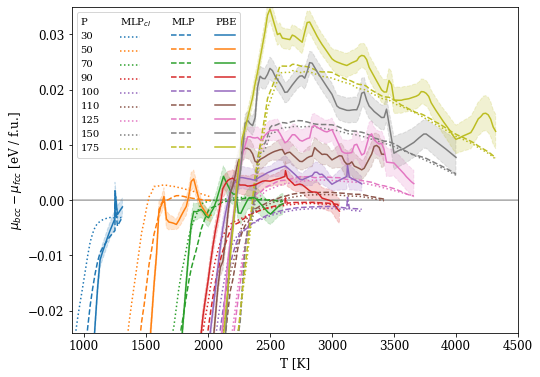

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)


p_plot_list = [30, 50, 70,90,100, 110,125,150,175]

xr = np.arange(100,5200)
ax.plot(xr, xr*0.0, c='gray',ls='-',alpha=0.7)

sys_now = 'bcc'
mu_ti_bcc_w_nqe = {}

for j, p in enumerate(p_plot_list):
        
    if p not in mu_ti_ref_fcc[sys_now] or len(mu_ti_ref_fcc[sys_now][p]) < 2: continue
    
    # T_m at the MLP level
    tm_now_mlp = mu_ti[sys_now][p][0,0] 
    # plot the mu from TI at the mlp level
    mu_ti_tmp = np.asarray([ m for m in mu_ti_ref_fcc[sys_now][p] if m[0] < tm_now_mlp and not isnan(m[1]) ])            
    mu_ti_tmp = mu_ti_tmp[mu_ti_tmp[:,0].argsort()] 
    ax.plot(mu_ti_tmp[:,0], mu_ti_tmp[:,1], 
            c=cm.tab10(j), alpha=1., ls='dotted', label="P="+str(p)+' MLP')

for j, p in enumerate(p_plot_list):
    if p not in mu_ti_ref_fcc[sys_now] or len(mu_ti_ref_fcc[sys_now][p]) < 2: continue
    
    # T_m at the MLP level
    tm_now_mlp = mu_ti[sys_now][p][0,0] 
    # plot the mu from TI at the mlp level
    mu_ti_tmp = np.asarray([ m for m in mu_ti_ref_fcc[sys_now][p] if m[0] < tm_now_mlp and not isnan(m[1]) ])            
    mu_ti_tmp = mu_ti_tmp[mu_ti_tmp[:,0].argsort()] 
    
    # add NQEs
    y = 1
    data = mu_nqe_by_y[sys_now][y][:,[2,1,3]]
    nqe_on_grid = 0.5*(2./y)*(y_list[0]-y_list[1])*\
            griddata(data[:,[0,1]], data[:,2], 
                     (p, mu_ti_tmp[:,0]), method='linear')

    data_ref = mu_nqe_by_y['fcc'][y][:,[2,1,3]]
    nqe_on_grid_ref = 0.5*(2./y)*(y_list[0]-y_list[1])*\
            griddata(data_ref[:,[0,1]], data_ref[:,2], 
                     (p, mu_ti_tmp[:,0]), method='linear')
        
    for yi, y in enumerate(y_list[1:-1]):
        data = mu_nqe_by_y[sys_now][y][:,[2,1,3]]
        grid_z1 = griddata(data[:,[0,1]], data[:,2], (p, mu_ti_tmp[:,0]), method='linear')
        nqe_on_grid = nqe_on_grid + (2./y)*(y_list[yi]-y_list[yi+1])*grid_z1
            
        data_ref = mu_nqe_by_y['fcc'][y][:,[2,1,3]]
        grid_z1 = griddata(data_ref[:,[0,1]], data_ref[:,2], 
                               (p, mu_ti_tmp[:,0]), method='linear')
        nqe_on_grid_ref = nqe_on_grid_ref + (2./y)*(y_list[yi]-y_list[yi+1])*grid_z1
        
    mu_ti_bcc_w_nqe[p] = np.vstack((mu_ti_tmp[:,0], mu_ti_tmp[:,1]+nqe_on_grid-nqe_on_grid_ref)).T
            
    ax.plot(mu_ti_bcc_w_nqe[p][:,0], mu_ti_bcc_w_nqe[p][:,1], 
                c=cm.tab10(j), ls='--', label="P="+str(p)+' MLP')
        

for j, p in enumerate(p_plot_list):
    # tm at the DFT level
    tm_now = tm_dft[sys_now][p]
            
    # add the mu_DFT - mu_NNP correction term
    data = mu_nnp2dft[sys_now][:,[0,1,2,3]]
    data_ref = mu_nnp2dft['fcc'][:,[0,1,2,3]]
    
    # add on classical data
    #mu_ti_tmp = np.asarray([ m for m in mu_ti_ref_fcc[sys_now][p] if m[0] < tm_now and not isnan(m[1]) ])  
    #mu_ti_tmp = mu_ti_tmp[mu_ti_tmp[:,0].argsort()] 
    
    # add on NQE data
    mu_ti_tmp = mu_ti_bcc_w_nqe[p]
    
    # add on ti data 
    dmu_nnp2dft_now = griddata(data[:,[0,1]], data[:,2], (p, mu_ti_tmp[:,0]), method='linear')
    dmu_nnp2dft_ref = griddata(data_ref[:,[0,1]], data_ref[:,2], (p, mu_ti_tmp[:,0]), method='linear')
    dmu_nnp2dft_now_error = griddata(data[:,[0,1]], data[:,3], (p, mu_ti_tmp[:,0]), method='linear')
    dmu_nnp2dft_ref_error = griddata(data_ref[:,[0,1]], data_ref[:,3], (p, mu_ti_tmp[:,0]), method='linear')

    mu_ti_corr = np.zeros((len(mu_ti_tmp),2))
    mu_ti_corr[:,0] = dmu_nnp2dft_now-dmu_nnp2dft_ref
    mu_ti_corr[:,1] = np.sqrt(dmu_nnp2dft_now_error**2.+dmu_nnp2dft_ref_error**2.)
        
    ax.plot(mu_ti_tmp[:,0], mu_ti_tmp[:,1]+mu_ti_corr[:,0], 
                    c=cm.tab10(j),ls='-', label='DFT')
        
    ax.fill_between(mu_ti_tmp[:,0], 
                    mu_ti_tmp[:,1]+mu_ti_corr[:,0]-mu_ti_corr[:,1], 
                    mu_ti_tmp[:,1]+mu_ti_corr[:,0]+mu_ti_corr[:,1],
             alpha=0.2, edgecolor=cm.tab10(j), facecolor=cm.tab10(j),
             linewidth=1, linestyle='--', antialiased=True)
        
tablelegend(ax, ncol=3, loc='upper left', fontsize=10,
            col_labels=['MLP$_{cl}$','MLP','PBE'], 
            row_labels=[ str(p) for p in p_plot_list], 
            title_label='P')

ax.set_xlim([900, 4500])
ax.set_ylim([-0.024,0.035])
ax.set_ylabel('$\mu_{bcc} - \mu_{fcc}$ [eV / f.u.]')
ax.set_xlabel("T [K]")

fig.savefig("mu_ref_fcc.pdf", dpi=300)

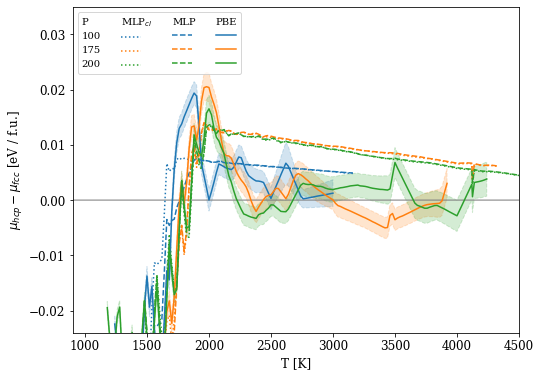

In [43]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)


p_plot_list = [100, 175,200]

xr = np.arange(100,5200)
ax.plot(xr, xr*0.0, c='gray',ls='-',alpha=0.7)

sys_now = 'Pbcm'
mu_ti_hcp_w_nqe = {}

for j, p in enumerate(p_plot_list):
        
    if p not in mu_ti_ref_fcc[sys_now] or len(mu_ti_ref_fcc[sys_now][p]) < 2: continue
    
    # T_m at the MLP level
    tm_now_mlp = mu_ti[sys_now][p][0,0] 
    # plot the mu from TI at the mlp level
    mu_ti_tmp = np.asarray([ m for m in mu_ti_ref_fcc[sys_now][p] if m[0] < tm_now_mlp and not isnan(m[1]) ])            
    mu_ti_tmp = mu_ti_tmp[mu_ti_tmp[:,0].argsort()] 
    ax.plot(mu_ti_tmp[:,0], mu_ti_tmp[:,1], 
            c=cm.tab10(j), alpha=1., ls='dotted', label="P="+str(p)+' MLP')

for j, p in enumerate(p_plot_list):
    if p not in mu_ti_ref_fcc[sys_now] or len(mu_ti_ref_fcc[sys_now][p]) < 2: continue
    
    # T_m at the MLP level
    tm_now_mlp = mu_ti[sys_now][p][0,0] 
    # plot the mu from TI at the mlp level
    mu_ti_tmp = np.asarray([ m for m in mu_ti_ref_fcc[sys_now][p] if m[0] < tm_now_mlp and not isnan(m[1]) ])            
    mu_ti_tmp = mu_ti_tmp[mu_ti_tmp[:,0].argsort()] 
    
    # add NQEs
    y = 1
    data = mu_nqe_by_y[sys_now][y][:,[2,1,3]]
    nqe_on_grid = 0.5*(2./y)*(y_list[0]-y_list[1])*\
            griddata(data[:,[0,1]], data[:,2], 
                     (p, mu_ti_tmp[:,0]), method='linear')

    data_ref = mu_nqe_by_y['fcc'][y][:,[2,1,3]]
    nqe_on_grid_ref = 0.5*(2./y)*(y_list[0]-y_list[1])*\
            griddata(data_ref[:,[0,1]], data_ref[:,2], 
                     (p, mu_ti_tmp[:,0]), method='linear')
        
    for yi, y in enumerate(y_list[1:-1]):
        data = mu_nqe_by_y[sys_now][y][:,[2,1,3]]
        grid_z1 = griddata(data[:,[0,1]], data[:,2], (p, mu_ti_tmp[:,0]), method='linear')
        nqe_on_grid = nqe_on_grid + (2./y)*(y_list[yi]-y_list[yi+1])*grid_z1
            
        data_ref = mu_nqe_by_y['fcc'][y][:,[2,1,3]]
        grid_z1 = griddata(data_ref[:,[0,1]], data_ref[:,2], 
                               (p, mu_ti_tmp[:,0]), method='linear')
        nqe_on_grid_ref = nqe_on_grid_ref + (2./y)*(y_list[yi]-y_list[yi+1])*grid_z1
        
    mu_ti_hcp_w_nqe[p] = np.vstack((mu_ti_tmp[:,0], mu_ti_tmp[:,1]+nqe_on_grid-nqe_on_grid_ref)).T
            
    ax.plot(mu_ti_hcp_w_nqe[p][:,0], mu_ti_hcp_w_nqe[p][:,1], 
                c=cm.tab10(j), ls='--', label="P="+str(p)+' MLP')
        

for j, p in enumerate(p_plot_list):
    # tm at the DFT level
    tm_now = tm_dft[sys_now][p]
            
    # add the mu_DFT - mu_NNP correction term
    data = mu_nnp2dft[sys_now][:,[0,1,2,3]]
    data_ref = mu_nnp2dft['fcc'][:,[0,1,2,3]]
    
    # add on classical data
    #mu_ti_tmp = np.asarray([ m for m in mu_ti_ref_fcc[sys_now][p] if m[0] < tm_now and not isnan(m[1]) ])  
    #mu_ti_tmp = mu_ti_tmp[mu_ti_tmp[:,0].argsort()] 
    
    # add on NQE data
    mu_ti_tmp = mu_ti_hcp_w_nqe[p]
    
    # add on ti data 
    dmu_nnp2dft_now = griddata(data[:,[0,1]], data[:,2], (p, mu_ti_tmp[:,0]), method='linear')
    dmu_nnp2dft_ref = griddata(data_ref[:,[0,1]], data_ref[:,2], (p, mu_ti_tmp[:,0]), method='linear')
    dmu_nnp2dft_now_error = griddata(data[:,[0,1]], data[:,3], (p, mu_ti_tmp[:,0]), method='linear')
    dmu_nnp2dft_ref_error = griddata(data_ref[:,[0,1]], data_ref[:,3], (p, mu_ti_tmp[:,0]), method='linear')

    mu_ti_corr = np.zeros((len(mu_ti_tmp),2))
    mu_ti_corr[:,0] = dmu_nnp2dft_now-dmu_nnp2dft_ref
    mu_ti_corr[:,1] = np.sqrt(dmu_nnp2dft_now_error**2.+dmu_nnp2dft_ref_error**2.)
        
    ax.plot(mu_ti_tmp[:,0], mu_ti_tmp[:,1]+mu_ti_corr[:,0], 
                    c=cm.tab10(j),ls='-', label='DFT')
        
    ax.fill_between(mu_ti_tmp[:,0], 
                    mu_ti_tmp[:,1]+mu_ti_corr[:,0]-mu_ti_corr[:,1], 
                    mu_ti_tmp[:,1]+mu_ti_corr[:,0]+mu_ti_corr[:,1],
             alpha=0.2, edgecolor=cm.tab10(j), facecolor=cm.tab10(j),
             linewidth=1, linestyle='--', antialiased=True)
        
tablelegend(ax, ncol=3, loc='upper left', fontsize=10,
            col_labels=['MLP$_{cl}$','MLP','PBE'], 
            row_labels=[ str(p) for p in p_plot_list], 
            title_label='P')

ax.set_xlim([900, 4500])
ax.set_ylim([-0.024,0.035])
ax.set_ylabel('$\mu_{hcp} - \mu_{fcc}$ [eV / f.u.]')
ax.set_xlabel("T [K]")

fig.savefig("mu_hcp_ref_fcc.pdf", dpi=300)

### dmu across P,T 

In [44]:
# check one gets the same dmu regardless of the TI routes
p_final = 500

for t in np.arange(2750, 5500, 200) :
    print(t,
          get_dmu(mlpeos['fcc'][:,[0,1,2,4]], 100, 3250, p_final, t,2)
          -get_dmu(mlpeos['bcc'][:,[0,1,2,4]], 100, 3250, p_final, t,2),
        get_dmu(mlpeos['fcc'][:,[0,1,2,4]], 100, 3250, p_final, t,1)
          -get_dmu(mlpeos['bcc'][:,[0,1,2,4]], 100, 3250, p_final, t,1),
        get_dmu(mlpeos['fcc'][:,[0,1,2,4]], 100, 3250, p_final, t)
          -get_dmu(mlpeos['bcc'][:,[0,1,2,4]], 100, 3250, p_final, t)
         )

2750 -0.08680884553723445 -0.08741344837946485 -0.08528775261358845
2950 -0.081872327739962 -0.08136217781966693 -0.08014408120806849
3150 -0.07703298652986135 -0.07543160370607538 -0.07620609203248563
3350 -0.07236596370435677 -0.07295357723371154 -0.07365699602620523
3550 -0.06771650293049447 -0.06682790982766917 -0.068695130544139
3750 -0.06338261294405356 nan -0.06303081783181952
3950 -0.05913518332334888 nan -0.059193753812827765
4150 -0.05507421722971273 nan -0.055367007072028684
4350 -0.051288408099324556 nan -0.05117103003795265
4550 -0.04755389130463428 nan -0.04818092130659579
4750 -0.044134326640360655 nan -0.04554855261259405
4950 -0.04082161746787705 nan -0.04094580143538451
5150 -0.03748913739473991 nan -0.037937934606350865
5350 -0.034317148493869354 nan -0.03507187112672483


In [45]:
# compute the offset using [100, 3250] as a reference point

offset100_3250 = {}

offset100_3250['fcc'] = 0.0

for i,sys_now in enumerate(['Pbcm','bcc','liquid']):
    dif_sum = 0.0
    weight_sum = 0.0
    dif_weighted_sum = 0.0
    n_data = 0
    
    PTVEdata = mlpeos[sys_now][:,[0,1,2,4]] 
    PTVEdata_2 = mlpeos['fcc'][:,[0,1,2,4]]

    for j, p in enumerate(P_list_mu):
        
        if sys_now == 'liquid':
            mu_tmp = np.squeeze(avg_mlpmu_by_P['fcc'][p])
        else:
            mu_tmp = np.squeeze(avg_mlpmu_by_P[sys_now][p])
        #print(sys_now, p, mu_tmp)         
        mu_ref = np.squeeze(avg_mlpmu_by_P['fcc'][p])
        if len(mu_tmp.shape) < 2 or len(mu_ref.shape) < 2: continue   
        
        mu_ref = np.asarray([ m for m in mu_ref if m[1] in mu_tmp[:,1]])
        mu_tmp = np.asarray([ m for m in mu_tmp if m[1] in mu_ref[:,1]])
        
        mu_ref = mu_ref[mu_ref[:,1].argsort()]
        mu_tmp = mu_tmp[mu_tmp[:,1].argsort()]
        
        for k in range(len(mu_ref)):
            if sys_now == 'liquid': mu_tmp[k,2] = 0.0
            [t, dmu_now] = mu_ref[k,1], mu_tmp[k,2]-mu_ref[k,2]
            mu_est = get_dmu(PTVEdata, 100, 3250, p, t) - get_dmu(PTVEdata_2, 100, 3250, p, t)
            if isnan(mu_est): continue
            #print(p, t, dmu_now, mu_est)
            if isnan(mu_tmp[k,3]): mu_tmp[k,3] = 0.005
            weight = np.exp(-np.sqrt(mu_tmp[k,3]**2.+mu_ref[k,3]**2.)/0.001)
            dif_sum += (dmu_now - mu_est)*(3250/t)
            weight_sum += weight
            dif_weighted_sum += weight*(dmu_now - mu_est)*(3250/t)
            n_data += 1
            
    print(sys_now, n_data, dif_sum/n_data, dif_weighted_sum/weight_sum)
    offset100_3250[sys_now] = dif_weighted_sum/weight_sum

Pbcm 10 0.0038928835212893196 0.004604967595943038
bcc 79 -0.0013521478144787591 -0.0012238641293354467
liquid 88 -0.0008662209578206472 -0.0007338723740868046


In [ ]:
# compare with the interface pinning data

mu_ti_ref_fcc = {}

sys_1='bcc'
sys_2='fcc'
PTVEdata = mlpeos[sys_1][:,[0,1,2,4]] 
PTVEdata_2 = mlpeos[sys_2][:,[0,1,2,4]]

t_list = np.arange(1000, 4500, 50)

mu_ti_bcc_fcc = {}
    
for p in P_list_mu:
    mu_ti_bcc_fcc[p] = np.zeros((len(t_list),2))
    for i, t in enumerate(t_list):
        mu_est = offset100_3250[sys_1]*t/3250 + get_dmu(PTVEdata, 100, 3250, p, t) - get_dmu(PTVEdata_2, 100, 3250, p, t)            
        mu_ti_bcc_fcc[p][i] = [t, mu_est]

Text(0.5, 0, 'T [$K$]')

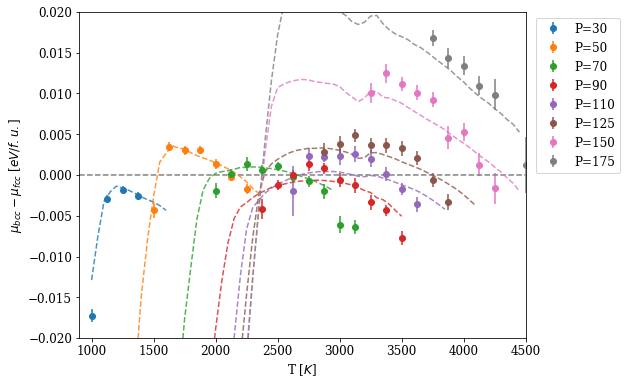

In [47]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)

xr = np.arange(100,5000)
ax.plot(xr, xr*0.0, c='gray',ls='--')

for i,sys_now in enumerate(['bcc']):

    for j, p in enumerate([30, 50, 70,90,110,125,150,175]): #P_list_mu):
        #"""        
        ax.plot(mu_ti_bcc_fcc[p][:,0], mu_ti_bcc_fcc[p][:,1], c=cm.tab10(j), alpha=0.8, ls='--')
        #"""            
        
        mu_tmp = np.squeeze(avg_mlpmu_by_P[sys_now][p])
        #print(sys_now, p, mu_tmp)
        if len(mu_tmp) < 2: continue            
        mu_ref = np.squeeze(avg_mlpmu_by_P['fcc'][p])
        
        mu_ref = np.asarray([ m for m in mu_ref if m[1] in mu_tmp[:,1]])
        mu_tmp = np.asarray([ m for m in mu_tmp if m[1] in mu_ref[:,1]])
        
        mu_ref = mu_ref[mu_ref[:,1].argsort()]
        mu_tmp = mu_tmp[mu_tmp[:,1].argsort()]
        
        
        ax.errorbar(mu_tmp[:,1], mu_tmp[:,2]-mu_ref[:,2], yerr=mu_tmp[:,3]+mu_ref[:,3],
                    c=cm.tab10(j), marker='o', label="P="+str(p),ls='')
        
        
        #if len(mu_ti[sys_now][p]) > 0:
        #    ax.axvline(mu_ti[sys_now][p][0,0], c=cm.tab10(j), ls='--')
        #    ax.text(mu_ti[sys_now][p][0,0]-200,0.015-0.03*(j%2),'Tm('+str(p)+")")
            
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_xlim([900, 4500])
ax.set_ylim([-0.02,0.02])
ax.set_ylabel('$\mu_{bcc} - \mu_{fcc}$ [$eV/f.u.$]')
ax.set_xlabel("T [$K$]")

#fig.savefig("mu_ref_fcc.pdf", dpi=300)

In [48]:
# compare with the interface pinning data

mu_ti_ref_fcc = {}

sys_1='Pbcm'
sys_2='fcc'
PTVEdata = mlpeos[sys_1][:,[0,1,2,4]] 
PTVEdata_2 = mlpeos[sys_2][:,[0,1,2,4]]

t_list = np.arange(2000, 4500, 50)

mu_ti_Pbcm_fcc = {}
    
for p in [100,150,175,200]:
    mu_ti_Pbcm_fcc[p] = np.zeros((len(t_list),2))
    for i, t in enumerate(t_list):
        mu_est = offset100_3250[sys_1]*t/3250 + get_dmu(PTVEdata, 100, 3250, p, t) - get_dmu(PTVEdata_2, 100, 3250, p, t)            
        mu_ti_Pbcm_fcc[p][i] = [t, mu_est]

Text(0.5, 0, 'T [$K$]')

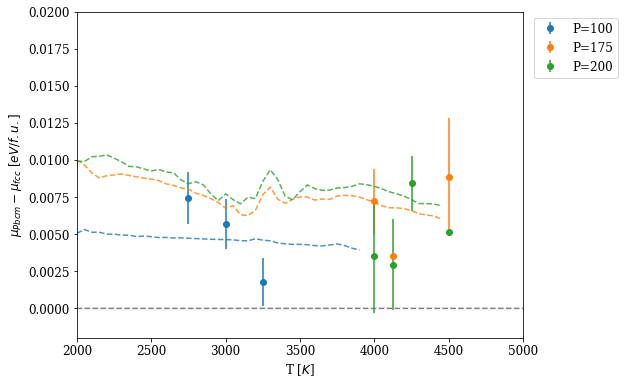

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)

xr = np.arange(100,5000)
ax.plot(xr, xr*0.0, c='gray',ls='--')

for i,sys_now in enumerate(['Pbcm']):

    for j, p in enumerate([100,175,200]): #P_list_mu):
        #"""        
        ax.plot(mu_ti_Pbcm_fcc[p][:,0], mu_ti_Pbcm_fcc[p][:,1], c=cm.tab10(j), alpha=0.8, ls='--')
        #"""            
        
        mu_tmp = np.squeeze(avg_mlpmu_by_P[sys_now][p])
        #print(sys_now, p, mu_tmp)
        if len(mu_tmp.shape) < 2: continue            
        mu_ref = np.squeeze(avg_mlpmu_by_P['fcc'][p])
        
        mu_ref = np.asarray([ m for m in mu_ref if m[1] in mu_tmp[:,1]])
        mu_tmp = np.asarray([ m for m in mu_tmp if m[1] in mu_ref[:,1]])
        
        mu_ref = mu_ref[mu_ref[:,1].argsort()]
        mu_tmp = mu_tmp[mu_tmp[:,1].argsort()]
        
        
        ax.errorbar(mu_tmp[:,1], mu_tmp[:,2]-mu_ref[:,2], yerr=mu_tmp[:,3]+mu_ref[:,3],
                    c=cm.tab10(j), marker='o', label="P="+str(p),ls='')
        
        
        #if len(mu_ti[sys_now][p]) > 0:
        #    ax.axvline(mu_ti[sys_now][p][0,0], c=cm.tab10(j), ls='--')
        #    ax.text(mu_ti[sys_now][p][0,0]-200,0.015-0.03*(j%2),'Tm('+str(p)+")")
            
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_xlim([2000, 5000])
ax.set_ylim([-0.002,0.02])
ax.set_ylabel('$\mu_{Pbcm} - \mu_{fcc}$ [$eV/f.u.$]')
ax.set_xlabel("T [$K$]")

#fig.savefig("mu_ref_fcc.pdf", dpi=300)

import dill
dill.load_session('notebook_env.db')

In [50]:
p_grid=np.exp(np.linspace(np.log(10), np.log(800), 80, endpoint=True))
t_grid=np.exp(np.linspace(np.log(300), np.log(5500), 60, endpoint=True))
X,Y = np.meshgrid(p_grid,t_grid)

In [51]:
nqe_on_grid = {}

for s in ['fcc', 'bcc', 'liquid','Pbcm']:
    
    # y = 1
    y = 1
    data = mu_nqe_by_y[s][y][:,[2,1,3]]
    nqe_on_grid[s] = 0.5*(2./y)*(y_list[0]-y_list[1])*griddata(data[:,[0,1]], data[:,2], (X, Y), method='linear')

    for i, y in enumerate(y_list[1:-1]):
        #print(y)
        data = mu_nqe_by_y[s][y][:,[2,1,3]]
        grid_z1 = griddata(data[:,[0,1]], data[:,2], (X, Y), method='linear')
        nqe_on_grid[s] = nqe_on_grid[s] + (2./y)*(y_list[i]-y_list[i+1])*grid_z1

In [52]:
for s in ['fcc', 'bcc', 'liquid','Pbcm']:
    mat_now = np.vstack((X.flatten(), Y.flatten(), nqe_on_grid[s].flatten())).T
    np.savetxt("./mu-data/mu-nqe-"+s+".dat", mat_now, header='P[GPa] T[K] Delta_mu^NQE [eV/f.u.]')

In [53]:
# MLP -> DFT
nnp2dft_on_grid = {}
nnp2dfterror_on_grid = {}

for s in ['fcc', 'bcc', 'liquid','Pbcm']:
    data = mu_nnp2dft[s][:,[0,1,2,3]]
    nnp2dft_on_grid[s] = griddata(data[:,[0,1]], data[:,2], 
                                  (X,Y), method='linear')
    nnp2dfterror_on_grid[s] = griddata(data[:,[0,1]], data[:,3], 
                                  (X,Y), method='linear')

In [54]:
for s in ['fcc', 'bcc', 'liquid','Pbcm']:
    mat_now = np.vstack((X.flatten(), Y.flatten(), nnp2dft_on_grid[s].flatten(), nnp2dfterror_on_grid[s].flatten())).T
    np.savetxt("./mu-data/mu-mlp2pbe-"+s+".dat", mat_now, 
               header='P[GPa] T[K] mu_PBE-mu_MLP [eV/f.u.] (mu_PBE-mu_MLP)_error [eV/f.u.]')

In [55]:
# TI results from classical MLP

mu_mlp_cl = {}

for s in ['fcc', 'bcc', 'liquid','Pbcm']:
    
    PTVEdata = mlpeos[s][:,[0,1,2,4]] 
    
    mu_mlp_cl[s] = 0.0 * X
    
    for i in range(np.shape(X)[0]):
        for j in range(np.shape(X)[1]):
            t_now = Y[i,j]
            t_start = 3250
            mu_mlp_cl[s][i,j] = offset100_3250[s]*t_now/t_start + get_dmu(PTVEdata, 100, 3250, X[i,j], Y[i,j])

In [56]:
for s in ['fcc', 'bcc', 'liquid','Pbcm']:
    mat_now = np.vstack((X.flatten(), Y.flatten(), mu_mlp_cl[s].flatten())).T
    np.savetxt("./mu-data/mu-mlp-cl-"+s+".dat", mat_now, header='P[GPa] T[K] mu_MLP,CL [eV/f.u.]')

In [57]:
# take the difference

dmu_bcc_fcc = mu_mlp_cl['bcc'] - mu_mlp_cl['fcc']
dmu_liquid_fcc = mu_mlp_cl['liquid'] - mu_mlp_cl['fcc']
dmu_Pbcm_fcc = mu_mlp_cl['Pbcm'] - mu_mlp_cl['fcc']
dmu_liquid_bcc = mu_mlp_cl['liquid'] - mu_mlp_cl['bcc']

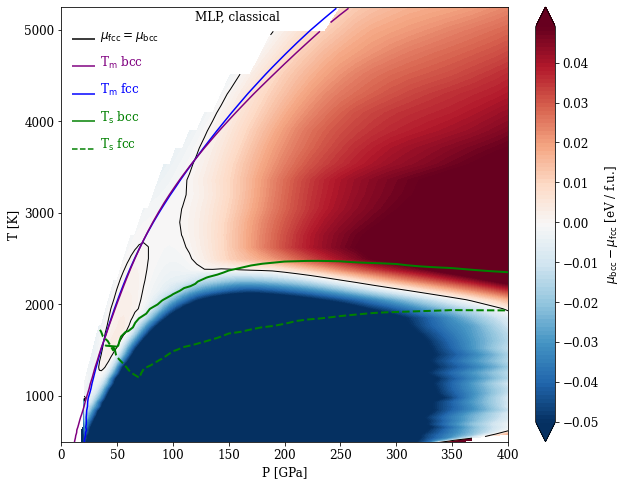

In [58]:
fig, ax = plt.subplots()
fig.set_size_inches(10,8)


CS = ax.contour(X, Y, 
                dmu_bcc_fcc,
                levels=[0.0], linewidths=1, colors='k')

cntr1 = ax.contourf(X, Y,  
                dmu_bcc_fcc,
                #+ nnp2dft_on_grid['bcc'] - nnp2dft_on_grid['fcc']
                #+ nqe_on_grid['bcc'] - nqe_on_grid['fcc'],
                levels=np.arange(-0.05,0.05,0.001), 
                    cmap="RdBu_r", extend='both')


# for ice <-> superionic transition
# P[GPa] T[K] 
ax.plot(mlpTs['bcc'][:,0],mlpTs['bcc'][:,1],ls='-',lw=2, c='green')
ax.text(35,4000,'T$_\mathrm{s}$ bcc',c='green')
ax.hlines(4000, 10, 30, colors='green', linestyles='solid', label='')
# P[GPa] T[K] 
ax.plot(mlpTs['fcc'][:,0],mlpTs['fcc'][:,1],ls='--',lw=2, c='green')
ax.text(35,3700,'T$_\mathrm{s}$ fcc',c='green')
ax.hlines(3700, 10, 30, colors='green', linestyles='--', label='')
##

ax.text(35,4900,'$\mu_\mathrm{fcc} = \mu_\mathrm{bcc}$',c='k')
ax.hlines(4900, 10, 30, colors='k', linestyles='solid', label='')

cbar = fig.colorbar(cntr1, ax=ax)
cbar.set_label('$\mu_\mathrm{bcc} - \mu_\mathrm{fcc}$ [eV / f.u.]')


# our Tm
tmfcc = ax.contour(X, Y, 
                dmu_liquid_fcc,
                #+ nnp2dft_on_grid['liquid'] - nnp2dft_on_grid['fcc']
                #+ nqe_on_grid['liquid'] - nqe_on_grid['fcc'],
                levels=[0.0],linewidths=1.5, colors='blue')
ax.text(35,4300,'T$_\mathrm{m}$ fcc',c='blue')
ax.hlines(4300, 10, 30, colors='blue', linestyles='solid', label='')

       
tmbcc = ax.contour(X, Y,
                dmu_liquid_bcc,
                #+ nnp2dft_on_grid['liquid'] - nnp2dft_on_grid['bcc']
                #+ nqe_on_grid['liquid'] - nqe_on_grid['bcc'],
                levels=[0.0],linewidths=1.5, colors='purple')
ax.text(35,4600,'T$_\mathrm{m}$ bcc',c='purple')
ax.hlines(4600, 10, 30, colors='purple', linestyles='solid', label='')


#ax.legend(ncol=2)
ax.set_xlabel('P [GPa]')
ax.set_ylabel("T [K]")
ax.set_xlim([0,400])
ax.set_ylim([500,5250])

ax.text(120,5100,'MLP, classical',c='k')

fig.savefig("phase-diagram-mlp-cl.pdf", dpi=300)

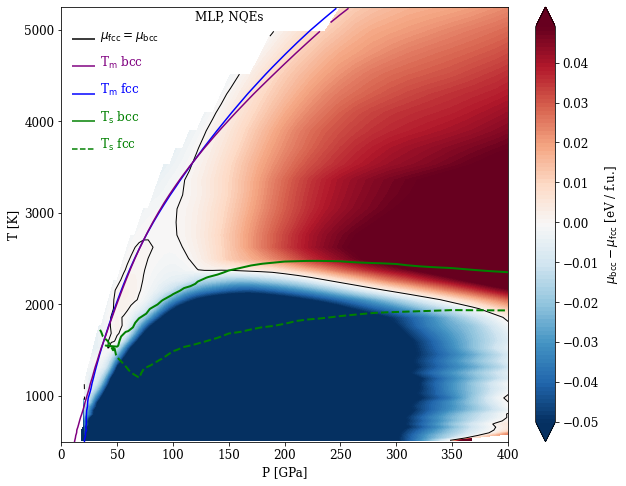

In [59]:
fig, ax = plt.subplots()
fig.set_size_inches(10,8)


CS = ax.contour(X, Y, 
                dmu_bcc_fcc+ nqe_on_grid['bcc'] - nqe_on_grid['fcc'],
                levels=[0.0], linewidths=1, colors='k')

cntr1 = ax.contourf(X, Y,  
                dmu_bcc_fcc+ nqe_on_grid['bcc'] - nqe_on_grid['fcc'],
                #+ nnp2dft_on_grid['bcc'] - nnp2dft_on_grid['fcc']
                #+ nqe_on_grid['bcc'] - nqe_on_grid['fcc'],
                levels=np.arange(-0.05,0.05,0.001), 
                    cmap="RdBu_r", extend='both')

# for ice <-> superionic transition
# P[GPa] T[K] 
ax.plot(mlpTs['bcc'][:,0],mlpTs['bcc'][:,1],ls='-',lw=2, c='green')
ax.text(35,4000,'T$_\mathrm{s}$ bcc',c='green')
ax.hlines(4000, 10, 30, colors='green', linestyles='solid', label='')
# P[GPa] T[K] 
ax.plot(mlpTs['fcc'][:,0],mlpTs['fcc'][:,1],ls='--',lw=2, c='green')
ax.text(35,3700,'T$_\mathrm{s}$ fcc',c='green')
ax.hlines(3700, 10, 30, colors='green', linestyles='--', label='')
##

ax.text(35,4900,'$\mu_\mathrm{fcc} = \mu_\mathrm{bcc}$',c='k')
ax.hlines(4900, 10, 30, colors='k', linestyles='solid', label='')

cbar = fig.colorbar(cntr1, ax=ax)
cbar.set_label('$\mu_\mathrm{bcc} - \mu_\mathrm{fcc}$ [eV / f.u.]')


# our Tm
tmfcc = ax.contour(X, Y, 
                dmu_liquid_fcc,
                #+ nnp2dft_on_grid['liquid'] - nnp2dft_on_grid['fcc']
                #+ nqe_on_grid['liquid'] - nqe_on_grid['fcc'],
                levels=[0.0],linewidths=1.5, colors='blue')
ax.text(35,4300,'T$_\mathrm{m}$ fcc',c='blue')
ax.hlines(4300, 10, 30, colors='blue', linestyles='solid', label='')

       
tmbcc = ax.contour(X, Y,
                dmu_liquid_bcc,
                #+ nnp2dft_on_grid['liquid'] - nnp2dft_on_grid['bcc']
                #+ nqe_on_grid['liquid'] - nqe_on_grid['bcc'],
                levels=[0.0],linewidths=1.5, colors='purple')
ax.text(35,4600,'T$_\mathrm{m}$ bcc',c='purple')
ax.hlines(4600, 10, 30, colors='purple', linestyles='solid', label='')

ax.text(120,5100,'MLP, NQEs',c='k')

#ax.legend(ncol=2)
ax.set_xlabel('P [GPa]')
ax.set_ylabel("T [K]")
ax.set_xlim([0,400])
ax.set_ylim([500,5250])

fig.savefig("phase-diagram-mlp-qm.pdf", dpi=300)

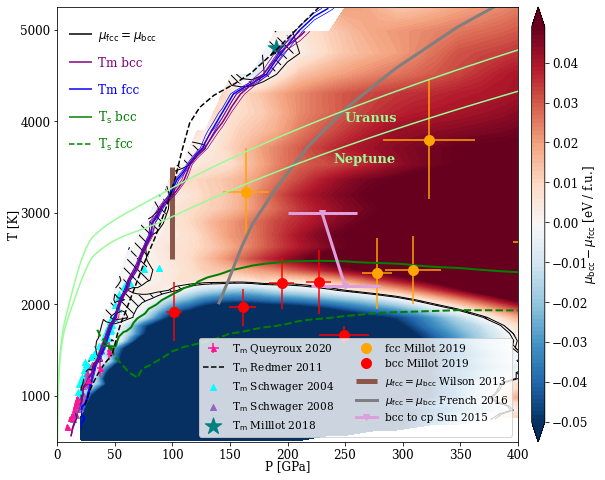

In [64]:
fig, ax = plt.subplots()
fig.set_size_inches(10,8)

CS = ax.contour(X, Y, 
                dmu_bcc_fcc
                +nnp2dft_on_grid['bcc']-nnp2dft_on_grid['fcc']
                +np.sqrt(nnp2dfterror_on_grid['bcc']**2.+nnp2dfterror_on_grid['fcc']**2.)
                +nqe_on_grid['bcc']-nqe_on_grid['fcc'], 
                levels=[0.0], linewidths=1, colors='k')
CS = ax.contour(X, Y, 
                dmu_bcc_fcc
                +nnp2dft_on_grid['bcc']-nnp2dft_on_grid['fcc']
                -np.sqrt(nnp2dfterror_on_grid['bcc']**2.+nnp2dfterror_on_grid['fcc']**2.)
                +nqe_on_grid['bcc']-nqe_on_grid['fcc'], 
                levels=[0.0], linewidths=1, colors='k')



cntr1 = ax.contourf(X, Y,  
                dmu_bcc_fcc
                + nnp2dft_on_grid['bcc'] - nnp2dft_on_grid['fcc']
                + nqe_on_grid['bcc'] - nqe_on_grid['fcc'],
                levels=np.arange(-0.05,0.05,0.001), 
                    cmap="RdBu_r", extend='both')

CS = ax.contourf(X, Y,  
                dmu_bcc_fcc
                + nnp2dft_on_grid['bcc'] - nnp2dft_on_grid['fcc']
                + nqe_on_grid['bcc'] - nqe_on_grid['fcc'],
                  levels=[-0.0014,0.0014], color='none',alpha=0.0,
                  hatches=[ None, '\\\\', None],
                  extend='both')


# for ice <-> superionic transition
# P[GPa] T[K] 
ax.plot(mlpTs['bcc'][:,0],mlpTs['bcc'][:,1],ls='-',lw=2, c='green')
ax.text(35,4000,'T$_\mathrm{s}$ bcc',c='green')
ax.hlines(4050, 10, 30, colors='green', linestyles='solid', label='')
# P[GPa] T[K] 
ax.plot(mlpTs['fcc'][:,0],mlpTs['fcc'][:,1],ls='--',lw=2, c='green')
ax.text(35,3700,'T$_\mathrm{s}$ fcc',c='green')
ax.hlines(3750, 10, 30, colors='green', linestyles='--', label='')
##

ax.text(35,4900,'$\mu_\mathrm{fcc} = \mu_\mathrm{bcc}$',c='k')
ax.hlines(4950, 10, 30, colors='k', linestyles='solid', label='')

#cbaxes = fig.add_axes([0.9, 0.1, 0.03, 0.8]) 
#cbar = plt.colorbar(cntr1, cax = cbaxes)  
cbar = fig.colorbar(cntr1, ax=ax,pad=0.025,aspect=30)
cbar.set_label('$\mu_\mathrm{bcc} - \mu_\mathrm{fcc}$ [eV / f.u.]',labelpad=-7)


# experiments
data_now = past_exp['Millot2019-bcc']
ax.errorbar(data_now[:,0], data_now[:,2], 
            yerr=data_now[:,3], xerr=data_now[:,1],
            label='bcc Millot 2019',
            marker='o', c='red', markersize=10,
           ls='')

data_now = past_exp['Millot2019-fcc']
ax.errorbar(data_now[:,0], data_now[:,2], 
            yerr=data_now[:,3], xerr=data_now[:,1],
            label='fcc Millot 2019',
            marker='o', c='orange', markersize=10,
           ls='')

# Prakapenka2020
"""
data_now = past_exp['Prakapenka2020-bcc']
ax.scatter(data_now[:,0], data_now[:,1], 
            label='bcc Prakapenka 2020',
            marker='D', c='red',s=100,facecolors='None', alpha=0.5)

data_now = past_exp['Prakapenka2020-fcc']
ax.scatter(data_now[:,0], data_now[:,1], 
            label='fcc Prakapenka 2020',
            marker='D', c='orange',s=100,facecolors='None', alpha=0.5)

data_now = past_exp['Prakapenka2020-ice']
ax.scatter(data_now[:,0], data_now[:,1], 
            label='ice Prakapenka 2020',
            marker='D', c='darkred',s=100,facecolors='None', alpha=0.5)
"""

data_now = past_exp['Schwager2004-melting']
ax.scatter(data_now[:,0], data_now[:,1], 
            label='T$_\mathrm{m}$ Schwager 2004',
            marker='^', c='aqua')
data_now = past_exp['Schwager2008-melting']
ax.scatter(data_now[:,0], data_now[:,1], 
            label='T$_\mathrm{m}$ Schwager 2008',
            marker='^', c='tab:purple')
data_now = past_exp['Queyroux2020-melting']
ax.errorbar(data_now[:,2], data_now[:,0], 
            yerr=data_now[:,1], xerr=data_now[:,3],
            label='T$_\mathrm{m}$ Queyroux 2020',
            marker='^', c='deeppink', markersize=5,
           ls='')

# millot 2018
ax.scatter([190], [4800], 
            label='T$_\mathrm{m}$ Milllot 2018',
            marker='*', s=300, c='teal')

"""
data_now = past_exp['Goncharov2005-melting']
ax.scatter(data_now[:,0], data_now[:,1], 
            label='T$_\mathrm{m}$ Goncharov 2005',
            marker='^', c='darkgreen')
"""

# theory
data_now = past_theory['French2016-bccfcc'] 
ax.plot(data_now[:,0], data_now[:,1], 
            label='$\mu_\mathrm{fcc}=\mu_\mathrm{bcc}$ French 2016',
            ls='-', lw=3, c='tab:gray')

"""
data_now = past_theory['Wilson2013-ice-superionic']
ax.scatter(data_now[:,0], data_now[:,1], 
            label='T$_\mathrm{s}$ Wilson 2013',
            marker='*', c='darkgreen',s=200)
"""

data_now = past_theory['Sun2015-bcc-cp']
ax.errorbar(data_now[:,1], data_now[:,0], 
            yerr=None, xerr=data_now[:,2],
            label='bcc to cp Sun 2015',
            marker='v', lw=3, c='plum')

# Wilson
ax.vlines(100, 2500, 3500, colors='tab:brown', 
          linestyles='solid', lw=5,
          label='$\mu_\mathrm{fcc}=\mu_\mathrm{bcc}$ Wilson 2013')

data_now = past_theory['Redmer2011-bcc-melt']
ax.plot(data_now[:,0], data_now[:,1], 
            label='T$_\mathrm{m}$ Redmer 2011',
            ls='--', c='k')
data_now = past_theory['Redmer2011-VII-melt'] 
ax.plot(data_now[:,0], data_now[:,1], 
            ls='--', c='k')
"""
data_now = past_theory['Redmer2011-VII-bcc']
ax.plot(data_now[:,0], data_now[:,1], 
            ls='--', c='k')
"""

handles, labels = plt.gca().get_legend_handles_labels()
order = [8,1,2,3,4,7,6,5,0,9]
#order = [7,1,2,3,4,5,6,0,8]
#order = [10,4,5,6,3,1,2,8,9,7,0,11]  # fig.savefig("phase-diagram-with-Prakapenka.pdf", dpi=300)
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
         loc='lower right', ncol=2, fontsize=10.5)

# our Tm
tmfcc = ax.contour(X, Y, 
                dmu_liquid_fcc
                + nnp2dft_on_grid['liquid'] - nnp2dft_on_grid['fcc']
                + nqe_on_grid['liquid'] - nqe_on_grid['fcc'],
                levels=[0.0],linewidths=1.5, colors='blue')
ax.text(35,4300,'Tm fcc',c='blue')
ax.hlines(4350, 10, 30, colors='blue', linestyles='solid', label='')

tmfccupper = ax.contour(X, Y, dmu_liquid_fcc
                        + nqe_on_grid['liquid'] - nqe_on_grid['fcc']
                        + nnp2dft_on_grid['liquid'] - nnp2dft_on_grid['fcc']
                        +np.sqrt(nnp2dfterror_on_grid['liquid']**2.+nnp2dfterror_on_grid['fcc']**2.),
                levels=[ 0.0],linewidths=0.7, colors='blue')
tmfcclower = ax.contour(X, Y, dmu_liquid_fcc
                        + nqe_on_grid['liquid'] - nqe_on_grid['fcc']
                        + nnp2dft_on_grid['liquid'] - nnp2dft_on_grid['fcc']
                        -np.sqrt(nnp2dfterror_on_grid['liquid']**2.+nnp2dfterror_on_grid['fcc']**2.),
                levels=[ 0.0],linewidths=0.7, colors='blue')

       
tmbcc = ax.contour(X, Y,
                dmu_liquid_bcc
                + nnp2dft_on_grid['liquid'] - nnp2dft_on_grid['bcc']
                + nqe_on_grid['liquid'] - nqe_on_grid['bcc'],
                levels=[0.0],linewidths=1.5, colors='purple')
ax.text(35,4600,'Tm bcc',c='purple')
ax.hlines(4650, 10, 30, colors='purple', linestyles='solid', label='')

tmbccupper = ax.contour(X, Y, dmu_liquid_bcc
                        + nqe_on_grid['liquid'] - nqe_on_grid['bcc']
                        + nnp2dft_on_grid['liquid'] - nnp2dft_on_grid['bcc']
                        +np.sqrt(nnp2dfterror_on_grid['liquid']**2.+nnp2dfterror_on_grid['bcc']**2.),
                levels=[ 0.0],linewidths=0.7, colors='purple')
tmbcclower = ax.contour(X, Y, dmu_liquid_bcc
                        + nqe_on_grid['liquid'] - nqe_on_grid['fcc']
                        + nnp2dft_on_grid['liquid'] - nnp2dft_on_grid['bcc']
                        -np.sqrt(nnp2dfterror_on_grid['liquid']**2.+nnp2dfterror_on_grid['bcc']**2.),
                levels=[ 0.0],linewidths=0.7, colors='purple')

# planatary conditions
data_now = past_theory['Scheibe2019-neptune'] 
ax.plot(data_now[:,1], data_now[:,3], 
            ls='-', c='palegreen')
ax.text(240,3550,'Neptune',c='palegreen',fontsize=13,weight="bold")

data_now = past_theory['Scheibe2019-uranus'] 
ax.plot(data_now[:,1], data_now[:,3], 
            ls='-', c='palegreen')
ax.text(250,4000,'Uranus',c='palegreen',fontsize=13,weight="bold")

#ax.legend(ncol=2)
ax.set_xlabel('P [GPa]', labelpad=-2)
ax.set_ylabel("T [K]", labelpad=-0)
ax.set_xlim([0,400])
ax.set_ylim([500,5250])

fig.savefig("phase-diagram.pdf", dpi=300,bbox_inches='tight')
#fig.savefig("phase-diagram-with-Prakapenka.pdf", dpi=300)

In [65]:
p = tmfcc.collections[0].get_paths()[2]
v = p.vertices
#print(v[v[:,1].argsort()])

#p = tmfccupper.collections[0].get_paths()[1]
#vupper = p.vertices
#print(vupper[vupper[:,1].argsort()])

#print(np.vstack((v[:,0], v[:,1])).T)
np.savetxt("./mu-data/Tm-fcc.dat", v[v[:,0].argsort()], header='P[GPa] T[K]')

p = tmbcc.collections[0].get_paths()[1]
v = p.vertices
#print(v[v[:,1].argsort()])

#p = tmfccupper.collections[0].get_paths()[1]
#vupper = p.vertices
#print(vupper[vupper[:,1].argsort()])

#print(np.vstack((v[:,0], v[:,1])).T)
np.savetxt("./mu-data/Tm-bcc.dat", v[v[:,0].argsort()], header='P[GPa] T[K]')

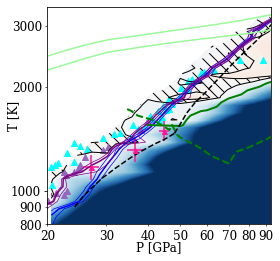

In [61]:
fig, ax = plt.subplots()
fig.set_size_inches(4,4)

CS = ax.contour(X, Y, 
                dmu_bcc_fcc
                +nnp2dft_on_grid['bcc']-nnp2dft_on_grid['fcc']
                +np.sqrt(nnp2dfterror_on_grid['bcc']**2.+nnp2dfterror_on_grid['fcc']**2.)
                +nqe_on_grid['bcc']-nqe_on_grid['fcc'], 
                levels=[0.0], linewidths=1, colors='k')
CS = ax.contour(X, Y, 
                dmu_bcc_fcc
                +nnp2dft_on_grid['bcc']-nnp2dft_on_grid['fcc']
                -np.sqrt(nnp2dfterror_on_grid['bcc']**2.+nnp2dfterror_on_grid['fcc']**2.)
                +nqe_on_grid['bcc']-nqe_on_grid['fcc'], 
                levels=[0.0], linewidths=1, colors='k')



cntr1 = ax.contourf(X, Y,  
                dmu_bcc_fcc
                + nnp2dft_on_grid['bcc'] - nnp2dft_on_grid['fcc']
                + nqe_on_grid['bcc'] - nqe_on_grid['fcc'],
                levels=np.arange(-0.05,0.05,0.001), 
                    cmap="RdBu_r", extend='both')

CS = ax.contourf(X, Y,  
                dmu_bcc_fcc
                + nnp2dft_on_grid['bcc'] - nnp2dft_on_grid['fcc']
                + nqe_on_grid['bcc'] - nqe_on_grid['fcc'],
                  levels=[-0.0014,0.0014], color='none',alpha=0.0,
                  hatches=[ None, '\\\\', None],
                  extend='both')


# for ice <-> superionic transition
# P[GPa] T[K] 
ax.plot(mlpTs['bcc'][:,0],mlpTs['bcc'][:,1],ls='-',lw=2, c='green')
#ax.text(35,4000,'Ts bcc',c='green')
#ax.hlines(4000, 10, 30, colors='green', linestyles='solid', label='')
# P[GPa] T[K] 
ax.plot(mlpTs['fcc'][:,0],mlpTs['fcc'][:,1],ls='--',lw=2, c='green')
#ax.text(35,3700,'Ts fcc',c='green')
#ax.hlines(3700, 10, 30, colors='green', linestyles='--', label='')
##

#cbar = fig.colorbar(cntr1, ax=ax)
#cbar.set_label('$\mu_{bcc} - \mu_{fcc}$ [$eV/f.u.$]')


# experiments
data_now = past_exp['Millot2019-bcc']
ax.errorbar(data_now[:,0], data_now[:,2], 
            yerr=data_now[:,3], xerr=data_now[:,1],
            label='bcc Millot 2019',
            marker='o', c='red', markersize=10,
           ls='')

data_now = past_exp['Millot2019-fcc']
ax.errorbar(data_now[:,0], data_now[:,2], 
            yerr=data_now[:,3], xerr=data_now[:,1],
            label='fcc Millot 2019',
            marker='o', c='orange', markersize=10,
           ls='')



data_now = past_exp['Schwager2004-melting']
ax.scatter(data_now[:,0], data_now[:,1], 
            label='T$_m$ Schwager 2004',
            marker='^', c='aqua')
data_now = past_exp['Schwager2008-melting']
ax.scatter(data_now[:,0], data_now[:,1], 
            label='T$_m$ Schwager 2008',
            marker='^', c='tab:purple')
data_now = past_exp['Queyroux2020-melting']
ax.errorbar(data_now[:,2], data_now[:,0], 
            yerr=data_now[:,1], xerr=data_now[:,3],
            label='T$_m$ Queyroux 2020',
            marker='^', c='deeppink', markersize=5,
           ls='')

# millot 2018
ax.scatter([190], [4800], 
            label='T$_m$ Milllot 2018',
            marker='*', s=300, c='teal')

"""
data_now = past_exp['Goncharov2005-melting']
ax.scatter(data_now[:,0], data_now[:,1], 
            label='T$_m$ Goncharov 2005',
            marker='^', c='darkgreen')
"""

# theory
data_now = past_theory['French2016-bccfcc'] 
ax.plot(data_now[:,0], data_now[:,1], 
            label='$\mu_{fcc}=\mu_{bcc}$ French 2016',
            ls='-', lw=3, c='tab:gray')

"""
data_now = past_theory['Wilson2013-ice-superionic']
ax.scatter(data_now[:,0], data_now[:,1], 
            label='T$_s$ Wilson 2013',
            marker='*', c='darkgreen',s=200)
"""

data_now = past_theory['Sun2015-bcc-cp']
ax.errorbar(data_now[:,1], data_now[:,0], 
            yerr=None, xerr=data_now[:,2],
            label='bcc to cp Sun 2015',
            marker='v', lw=3, c='plum')

# Wilson
ax.vlines(100, 2500, 3500, colors='tab:brown', 
          linestyles='solid', lw=5,
          label='$\mu_{fcc}=\mu_{bcc}$ Wilson 2013')

data_now = past_theory['Redmer2011-bcc-melt']
ax.plot(data_now[:,0], data_now[:,1], 
            label='T$_\mathrm{m}$ Redmer 2011',
            ls='--', c='k')
data_now = past_theory['Redmer2011-VII-melt'] 
ax.plot(data_now[:,0], data_now[:,1], 
            ls='--', c='k')
"""
data_now = past_theory['Redmer2011-VII-bcc']
ax.plot(data_now[:,0], data_now[:,1], 
            ls='--', c='k')
"""

handles, labels = plt.gca().get_legend_handles_labels()
order = [7,1,2,3,4,5,6,0,8]
#order = [10,4,5,6,3,1,2,8,9,7,0,11]  # fig.savefig("phase-diagram-with-Prakapenka.pdf", dpi=300)
#ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
#         loc='lower right', ncol=2, fontsize=10.5)

# our Tm
tmfcc = ax.contour(X, Y, 
                dmu_liquid_fcc
                + nnp2dft_on_grid['liquid'] - nnp2dft_on_grid['fcc']
                + nqe_on_grid['liquid'] - nqe_on_grid['fcc'],
                levels=[0.0],linewidths=1.5, colors='blue')
#ax.text(35,4300,'Tm fcc',c='blue')
#ax.hlines(4300, 10, 30, colors='blue', linestyles='solid', label='')

tmfccupper = ax.contour(X, Y, dmu_liquid_fcc
                        + nqe_on_grid['liquid'] - nqe_on_grid['fcc']
                        + nnp2dft_on_grid['liquid'] - nnp2dft_on_grid['fcc']
                        +np.sqrt(nnp2dfterror_on_grid['liquid']**2.+nnp2dfterror_on_grid['fcc']**2.),
                levels=[ 0.0],linewidths=0.7, colors='blue')
tmfcclower = ax.contour(X, Y, dmu_liquid_fcc
                        + nqe_on_grid['liquid'] - nqe_on_grid['fcc']
                        + nnp2dft_on_grid['liquid'] - nnp2dft_on_grid['fcc']
                        -np.sqrt(nnp2dfterror_on_grid['liquid']**2.+nnp2dfterror_on_grid['fcc']**2.),
                levels=[ 0.0],linewidths=0.7, colors='blue')

       
tmbcc = ax.contour(X, Y,
                dmu_liquid_bcc
                + nnp2dft_on_grid['liquid'] - nnp2dft_on_grid['bcc']
                + nqe_on_grid['liquid'] - nqe_on_grid['bcc'],
                levels=[0.0],linewidths=1.5, colors='purple')
#ax.text(35,4600,'Tm bcc',c='purple')
#ax.hlines(4600, 10, 30, colors='purple', linestyles='solid', label='')

tmbccupper = ax.contour(X, Y, dmu_liquid_bcc
                        + nqe_on_grid['liquid'] - nqe_on_grid['bcc']
                        + nnp2dft_on_grid['liquid'] - nnp2dft_on_grid['bcc']
                        +np.sqrt(nnp2dfterror_on_grid['liquid']**2.+nnp2dfterror_on_grid['bcc']**2.),
                levels=[ 0.0],linewidths=0.7, colors='purple')
tmbcclower = ax.contour(X, Y, dmu_liquid_bcc
                        + nqe_on_grid['liquid'] - nqe_on_grid['fcc']
                        + nnp2dft_on_grid['liquid'] - nnp2dft_on_grid['bcc']
                        -np.sqrt(nnp2dfterror_on_grid['liquid']**2.+nnp2dfterror_on_grid['bcc']**2.),
                levels=[ 0.0],linewidths=0.7, colors='purple')

# planatary conditions
"""
data_now = past_theory['Nettelmann2012-neptune'] 
ax.plot(data_now[:,1], data_now[:,3], 
            ls='-', c='palegreen')
ax.text(200,3820,'Neptune',c='palegreen',fontsize=13,weight="bold")

data_now = past_theory['Nettelmann2012-uranus'] 
ax.plot(data_now[:,1], data_now[:,4], 
            ls='-', c='palegreen')
ax.text(180,4240,'Uranus',c='palegreen',fontsize=13,weight="bold")
"""

data_now = past_theory['Scheibe2019-neptune'] 
ax.plot(data_now[:,1], data_now[:,3], 
            ls='-', c='palegreen')
#ax.text(240,3550,'Neptune',c='palegreen',fontsize=13,weight="bold")

data_now = past_theory['Scheibe2019-uranus'] 
ax.plot(data_now[:,1], data_now[:,3], 
            ls='-', c='palegreen')
#ax.text(250,4000,'Uranus',c='palegreen',fontsize=13,weight="bold")

#ax.legend(ncol=2)
ax.set_xlabel('P [GPa]',labelpad=-2)
ax.set_ylabel("T [K]",labelpad=-10)
ax.set_xlim([20,93])
ax.set_ylim([800,3400])

ax.set_xscale("log")
ax.set_yscale("log") 

from matplotlib.ticker import StrMethodFormatter, NullFormatter
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.yaxis.set_minor_formatter(StrMethodFormatter('{x:.0f}'))
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.xaxis.set_minor_formatter(StrMethodFormatter('{x:.0f}'))

fig.savefig("phase-diagram-lowP.pdf", dpi=300,bbox_inches='tight')
#fig.savefig("phase-diagram-with-Prakapenka.pdf", dpi=300)

(500.0, 5500.0)

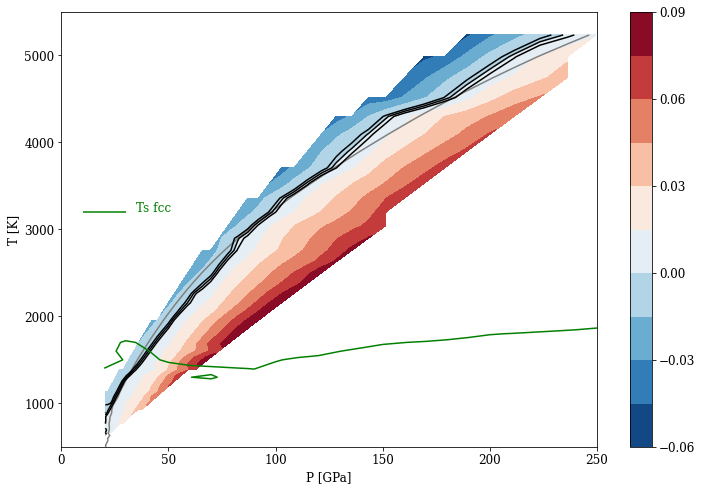

In [62]:
fig, ax = plt.subplots(figsize=(12,8))

CS = ax.contour(X, Y, dmu_liquid_fcc, levels=[0.0],linewidths=1.5, colors='gray')


tmfcc = ax.contour(X, Y, dmu_liquid_fcc+ nnp2dft_on_grid['liquid'] - nnp2dft_on_grid['fcc'],
                levels=[ 0.0],linewidths=1.5, colors='k')
cntr1 = ax.contourf(X, Y, dmu_liquid_fcc + nnp2dft_on_grid['liquid'] - nnp2dft_on_grid['fcc'],
                    levels=11, cmap="RdBu_r")

tmfccupper = ax.contour(X, Y, dmu_liquid_fcc+ nnp2dft_on_grid['liquid'] - nnp2dft_on_grid['fcc']
                        +np.sqrt(nnp2dfterror_on_grid['liquid']**2.+nnp2dfterror_on_grid['fcc']**2.),
                levels=[ 0.0],linewidths=1.5, colors='k')


tmfcclower = ax.contour(X, Y, dmu_liquid_fcc+ nnp2dft_on_grid['liquid'] - nnp2dft_on_grid['fcc']
                        -np.sqrt(nnp2dfterror_on_grid['liquid']**2.+nnp2dfterror_on_grid['fcc']**2.),
                levels=[ 0.0],linewidths=1.5, colors='k')


#ax.plot(mu_nnp2dft['fcc'][:,0], mu_nnp2dft['fcc'][:,1], 'k.', ms=10)
#ax.plot(mu_nnp2dft['liquid'][:,0], mu_nnp2dft['liquid'][:,1], 'r.', ms=5)

# for ice <-> superionic transition
dX,dY = np.meshgrid(np.arange(10, 800, 10), np.arange(100, 5000, 100))

# P[GPa] T[K] Do Do_error Dh Dh_error
data = np.asarray([a for a in allD['fcc'] if a[2]<1e-4 ])[:,[0,1,4]]
grid_z1 = griddata(data[:,[0,1]], data[:,2], (dX, dY), method='linear')
ax.contour(dX, dY, grid_z1, levels=[1e-4],linewidths=1.5, colors='green')
ax.text(35,3200,'Ts fcc',c='green')
ax.hlines(3200, 10, 30, colors='green', linestyles='solid', label='')

fig.colorbar(cntr1, ax=ax)

ax.set_xlabel('P [GPa]')
ax.set_ylabel("T [K]")
ax.set_xlim([0,250])
ax.set_ylim([500,5500])

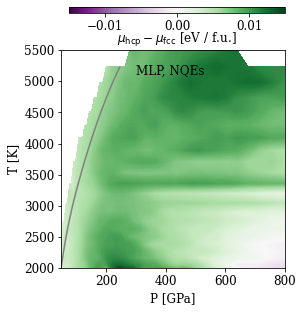

In [66]:
fig, ax = plt.subplots(figsize=(4,4))

cntr1 = ax.contourf(X, Y,  
                dmu_Pbcm_fcc
                #+ nnp2dft_on_grid['Pbcm'] - nnp2dft_on_grid['fcc']
                + nqe_on_grid['Pbcm'] - nqe_on_grid['fcc']
                    ,levels=np.arange(-0.015,0.015,0.0001), cmap="PRGn")


CS = ax.contour(X, Y, dmu_liquid_fcc, levels=[0.0],linewidths=1.5, colors='gray')

cbaxes = fig.add_axes([0.15, 1.01, 0.75, 0.02]) 
cbar = fig.colorbar(cntr1, cax = cbaxes,orientation='horizontal')
tick_locator = ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator
cbar.update_ticks()

cbar.set_label('$\mu_\mathrm{hcp} - \mu_\mathrm{fcc}$ [eV / f.u.]',fontsize=12, labelpad=-2)

ax.set_xlim([50,800])
ax.set_ylim([2000,5500])

ax.set_xlabel('P [GPa]')
ax.set_ylabel("T [K]")

#ax.text(300,5100,'MLP, classical',c='k')
ax.text(300,5100,'MLP, NQEs',c='k')

fig.savefig("fcc-hcp-phase-diagram-mlp.pdf", dpi=300,bbox_inches='tight')

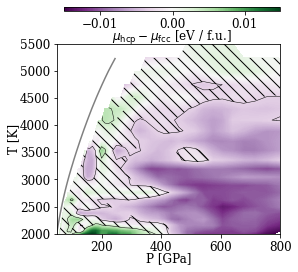

In [67]:
fig, ax = plt.subplots(figsize=(4,3.5))

cntr1 = ax.contourf(X, Y,  
                dmu_Pbcm_fcc
                + nnp2dft_on_grid['Pbcm'] - nnp2dft_on_grid['fcc']
                + nqe_on_grid['Pbcm'] - nqe_on_grid['fcc']
                    ,levels=np.arange(-0.015,0.015,0.0001), cmap="PRGn")

CS = ax.contour(X, Y,  
                dmu_Pbcm_fcc
                + nnp2dft_on_grid['Pbcm'] - nnp2dft_on_grid['fcc']
                + nqe_on_grid['Pbcm'] - nqe_on_grid['fcc']
                + nnp2dfterror_on_grid['Pbcm'] + nnp2dfterror_on_grid['fcc']
                ,levels=[0.000],linewidths=0.5, colors='k')

CS = ax.contour(X, Y,  
                dmu_Pbcm_fcc
                + nnp2dft_on_grid['Pbcm'] - nnp2dft_on_grid['fcc']
                + nqe_on_grid['Pbcm'] - nqe_on_grid['fcc']
                - (nnp2dfterror_on_grid['Pbcm'] + nnp2dfterror_on_grid['fcc'])
                ,levels=[0.000],linewidths=0.5, colors='k')

CS = ax.contourf(X, Y,  
                dmu_Pbcm_fcc
                + nnp2dft_on_grid['Pbcm'] - nnp2dft_on_grid['fcc']
                + nqe_on_grid['Pbcm'] - nqe_on_grid['fcc'],
                  levels=[-0.0031,0.0031], color='none',alpha=0.0,
                  hatches=[ None, '\\\\', None],
                  extend='both')

CS = ax.contour(X, Y, dmu_liquid_fcc, levels=[0.0],linewidths=1.5, colors='gray')

cbaxes = fig.add_axes([0.15, 1.01, 0.75, 0.015]) 
cbar = fig.colorbar(cntr1, cax = cbaxes,orientation='horizontal')
tick_locator = ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator
cbar.update_ticks()

cbar.set_label('$\mu_\mathrm{hcp} - \mu_\mathrm{fcc}$ [eV / f.u.]',fontsize=12, labelpad=-2)

ax.set_xlim([50,800])
ax.set_ylim([2000,5500])

ax.set_xlabel('P [GPa]',labelpad=-2)
ax.set_ylabel("T [K]",labelpad=-0.5)

fig.savefig("fcc-hcp-phase-diagram.pdf", dpi=300,bbox_inches='tight')

In [68]:
import dill
dill.dump_session('notebook_env.db')

In [ ]:
#import dill
#dill.load_session('notebook_env.db')